In [1]:
import pandas as pd

In [2]:
ling = pd.read_csv('ling.csv')
ling

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0
...,...,...,...
2854,win $ 300usd and a cruise !,"raquel 's casino , inc . is awarding a cruise ...",1
2855,you have been asked to join kiddin,"the list owner of : "" kiddin "" has invited you...",1
2856,anglicization of composers ' names,"judging from the return post , i must have sou...",0
2857,"re : 6 . 797 , comparative method : n - ary co...",gotcha ! there are two separate fallacies in t...,0


In [3]:
ling["label"].value_counts()

0    2401
1     458
Name: label, dtype: int64

In [4]:
ling["subject"]

0                 job posting - apple-iss research center
1                                                     NaN
2       query : letter frequencies for text identifica...
3                                                    risk
4                                request book information
                              ...                        
2854                          win $ 300usd and a cruise !
2855                   you have been asked to join kiddin
2856                   anglicization of composers ' names
2857    re : 6 . 797 , comparative method : n - ary co...
2858                 re : american - english in australia
Name: subject, Length: 2859, dtype: object

In [5]:
import sys

sys.path.append("../Handlers")

import preprocessing

[nltk_data] Downloading package punkt to E:/nltk...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
subject = "subject"
body = "body"
ling_input = ling.apply(lambda x: f"{x[subject]} {x[body]}", axis=1)

In [7]:
from functools import partial

preprocession = partial(
    preprocessing.preprocess_text,
    remove_numbers=True,
)

preprocessed_data = ling_input.apply(preprocession)
preprocessed_data

0       [job, posting, appleiss, research, center, con...
1       [nan, lang, classification, grimes, joseph, e,...
2       [query, letter, frequencies, text, identificat...
3       [risk, colleague, researching, differing, degr...
4       [request, book, information, earlier, morning,...
                              ...                        
2854    [win, usd, cruise, raquel, casino, inc, awardi...
2855    [asked, join, kiddin, list, owner, kiddin, inv...
2856    [anglicization, composers, names, judging, ret...
2857    [comparative, method, n, ary, comparison, gotc...
2858    [american, english, australia, hello, working,...
Length: 2859, dtype: object

In [8]:
import itertools

combined = list(itertools.chain.from_iterable(preprocessed_data))
len(combined)

778913

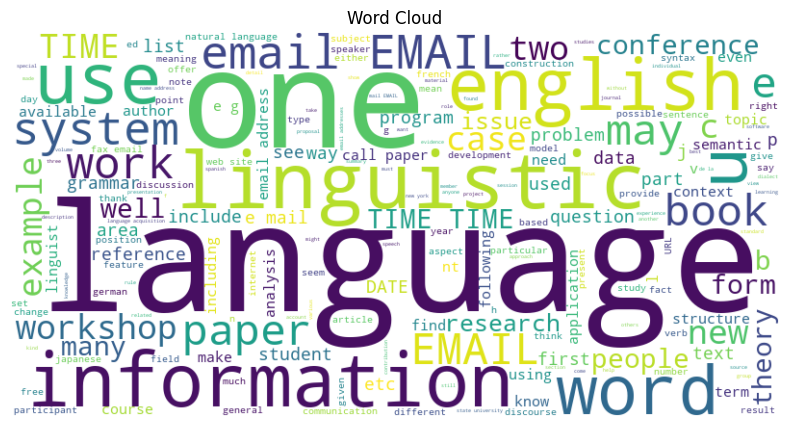

In [9]:
preprocessing.visualize_wordcloud(combined)

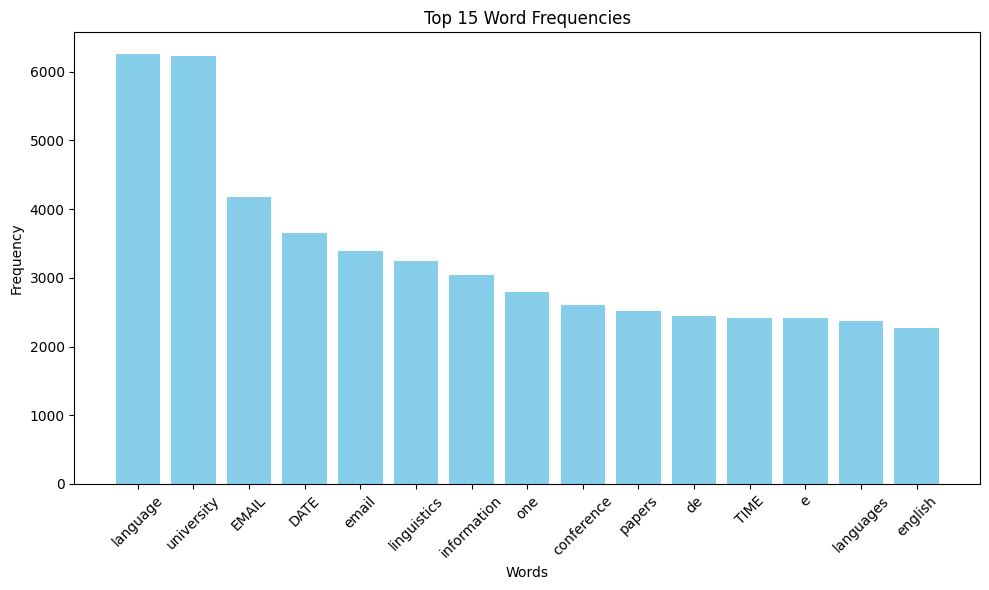

In [10]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(combined)
most_common = counter.most_common(15)

words, counts = zip(*most_common)

plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.title("Top 15 Word Frequencies")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

del combined

In [11]:
from traintest import ClassificationModel, get_classification_models, add_to_json_array
from concurrent.futures import ThreadPoolExecutor
from functools import partial

metric_results = []

def t_and_e(model, X, y, dataset_name):
    print(f"Begin classifying {model.__class__.__name__}")
    classification_model = ClassificationModel(model, dataset_name)
    classification_model.train_with_epochs(X, y, save_model=True, test_size=0.1, valid_size=0.1, epochs=5)
    print(f"{model.__class__.__name__} classification report")
    classification_model.plot_train_val_accuracy_after_epochs(xlabel="Epochs", ylabel="Accuracy")
    metrics = classification_model.evaluate(detailed=True)
    metric_results.append(metrics)
    print(metrics)
    print("\n")

def train_and_evaluate_model(X, y, dataset_name, m, threading=True):
    print(f"{dataset_name} classification report")
    print("=========================================")

    train_eval = partial(
        t_and_e,
        X=X,
        y=y,
        dataset_name=dataset_name,
    )

    if threading:
        with ThreadPoolExecutor(max_workers=3) as executor:
            executor.map(train_eval, m)
    else:
        for model in m:
            train_eval(model)

## Stemming + CountVectorizer

In [12]:
model = get_classification_models()

In [13]:
ling_stemming = preprocessed_data.apply(preprocessing.stemming)

In [14]:
ling_stemming_countvec = preprocessing.vectorizing(ling_stemming, "countvectorizer")

ling_stemmed_countvec classification report
Begin classifying SVC
Begin classifying MultinomialNB
Begin classifying BernoulliNB
MultinomialNB classification report
BernoulliNB classification report


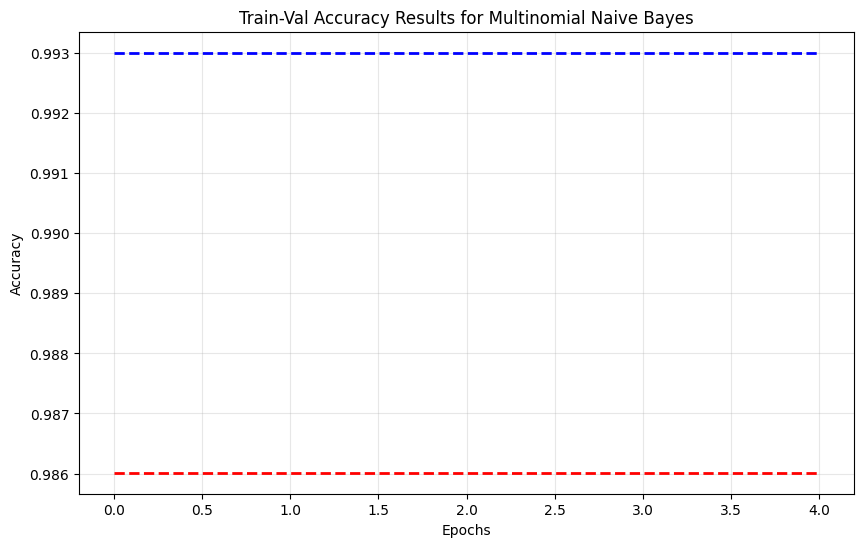

{'dataset': 'ling_stemmed_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896587286768166, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9895614229954126, 'macro_precision': 0.9746865728777874, 'macro_recall': 0.9839968774395004, 'macro_f1': 0.979272859040947, 'roc_auc': 0.9839968774395004}, 'confusion_matrix': array([[242,   2],
       [  1,  41]], dtype=int64)}


Begin classifying RandomForestClassifier


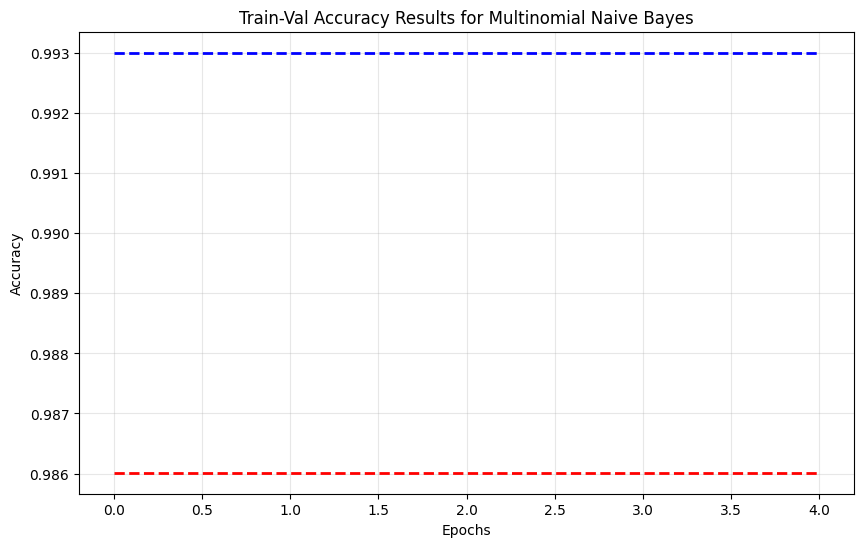

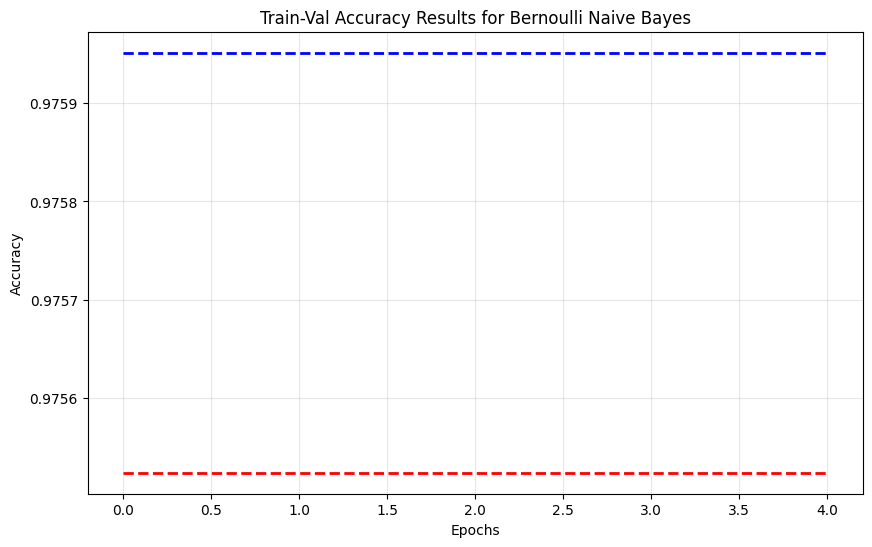

{'dataset': 'ling_stemmed_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.986013986013986, 'weighted_precision': 0.9862395668847281, 'wighted_recall': 0.986013986013986, 'weighted_f1': 0.9857211893797259, 'macro_precision': 0.9919354838709677, 'macro_recall': 0.9523809523809523, 'macro_f1': 0.9709349593495935, 'roc_auc': 0.9523809523809523}, 'confusion_matrix': array([[244,   0],
       [  4,  38]], dtype=int64)}


Begin classifying DecisionTreeClassifier
DecisionTreeClassifier classification report


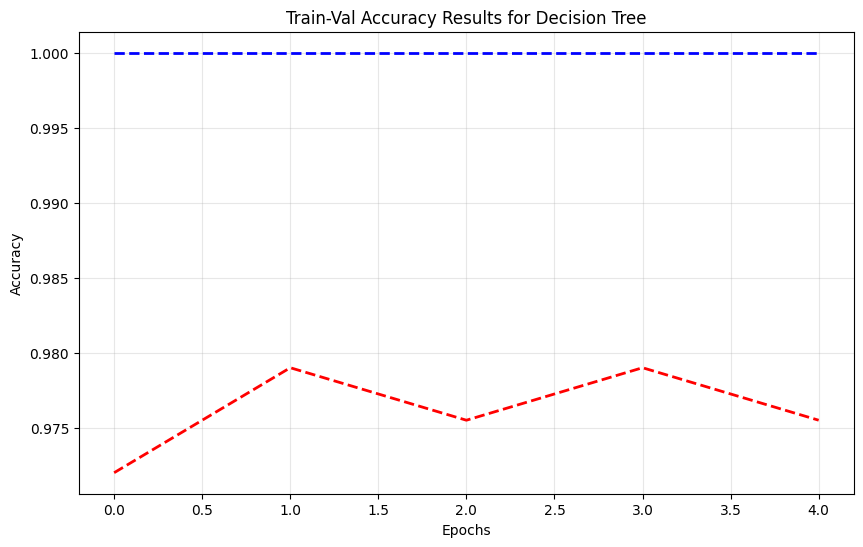

{'dataset': 'ling_stemmed_countvec', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.965034965034965, 'weighted_precision': 0.9658729700052016, 'wighted_recall': 0.965034965034965, 'weighted_f1': 0.9653695906925881, 'macro_precision': 0.9235537190082646, 'macro_recall': 0.9400858704137393, 'macro_f1': 0.9315723992726577, 'roc_auc': 0.9400858704137391}, 'confusion_matrix': array([[238,   6],
       [  4,  38]], dtype=int64)}


Begin classifying AdaBoostClassifier
RandomForestClassifier classification report


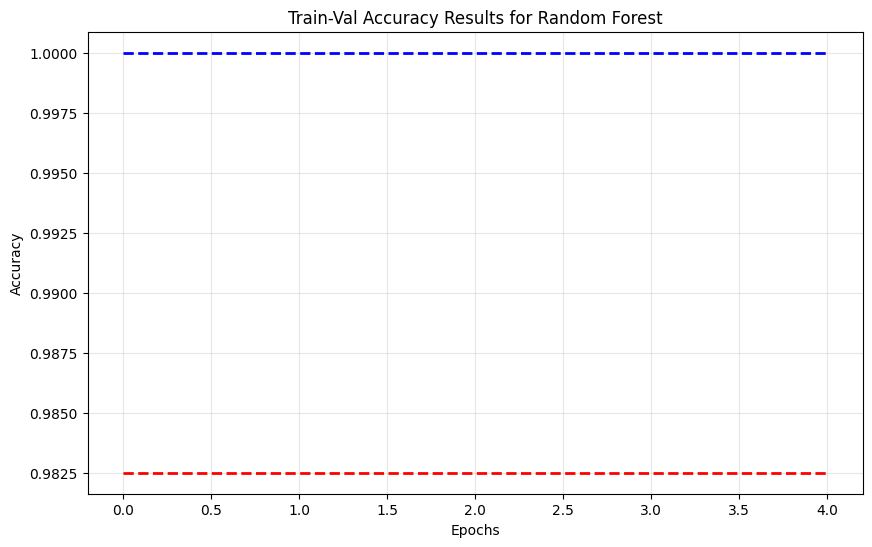

{'dataset': 'ling_stemmed_countvec', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896378924719007, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9893482846639668, 'macro_precision': 0.9939271255060729, 'macro_recall': 0.9642857142857143, 'macro_f1': 0.9784264916647809, 'roc_auc': 0.9642857142857143}, 'confusion_matrix': array([[244,   0],
       [  3,  39]], dtype=int64)}


Begin classifying LogisticRegression
AdaBoostClassifier classification report


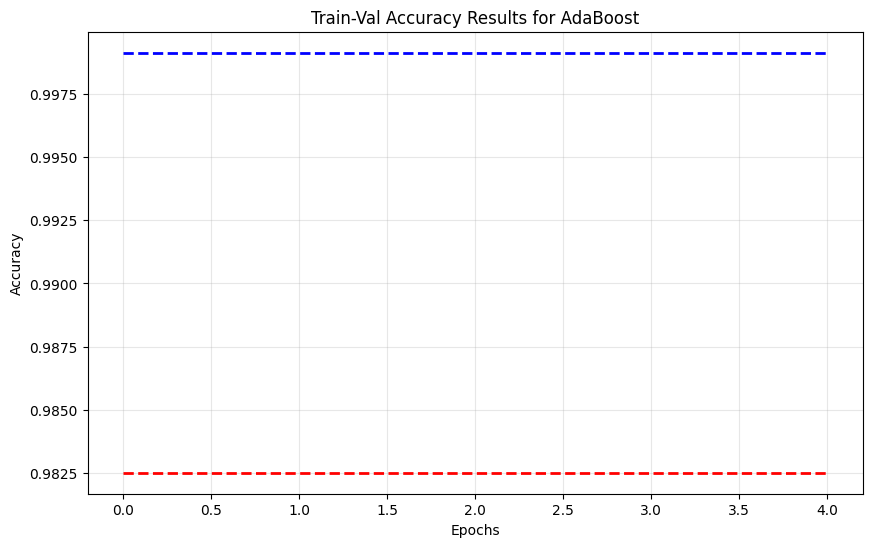

{'dataset': 'ling_stemmed_countvec', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965177679463395, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.9964860083863704, 'macro_precision': 0.9979591836734694, 'macro_recall': 0.9880952380952381, 'macro_f1': 0.9929534087269323, 'roc_auc': 0.9880952380952381}, 'confusion_matrix': array([[244,   0],
       [  1,  41]], dtype=int64)}


Begin classifying KNeighborsClassifier
KNeighborsClassifier classification report


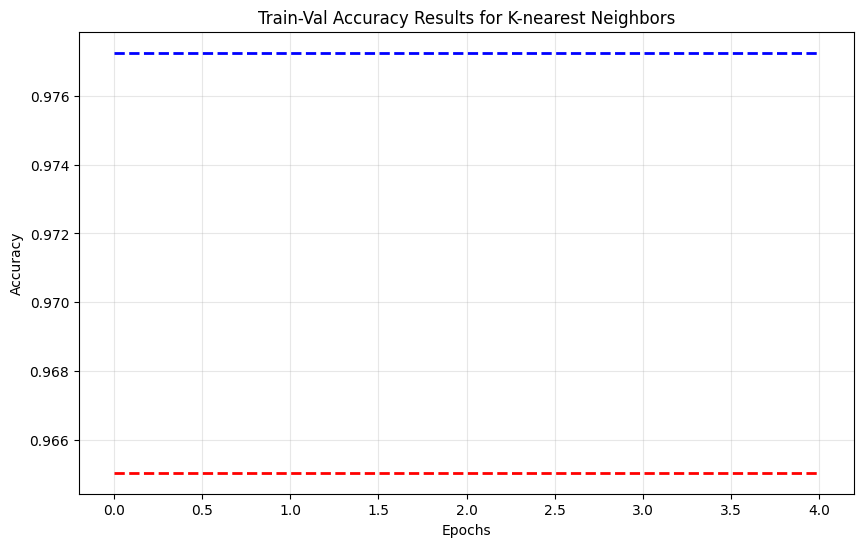

{'dataset': 'ling_stemmed_countvec', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.958041958041958, 'weighted_precision': 0.9590099982661966, 'wighted_recall': 0.958041958041958, 'weighted_f1': 0.9584435088311057, 'macro_precision': 0.9101239669421488, 'macro_recall': 0.9261319281811085, 'macro_f1': 0.9178868791271892, 'roc_auc': 0.9261319281811086}, 'confusion_matrix': array([[237,   7],
       [  5,  37]], dtype=int64)}


Begin classifying SGDClassifier
SGDClassifier classification report


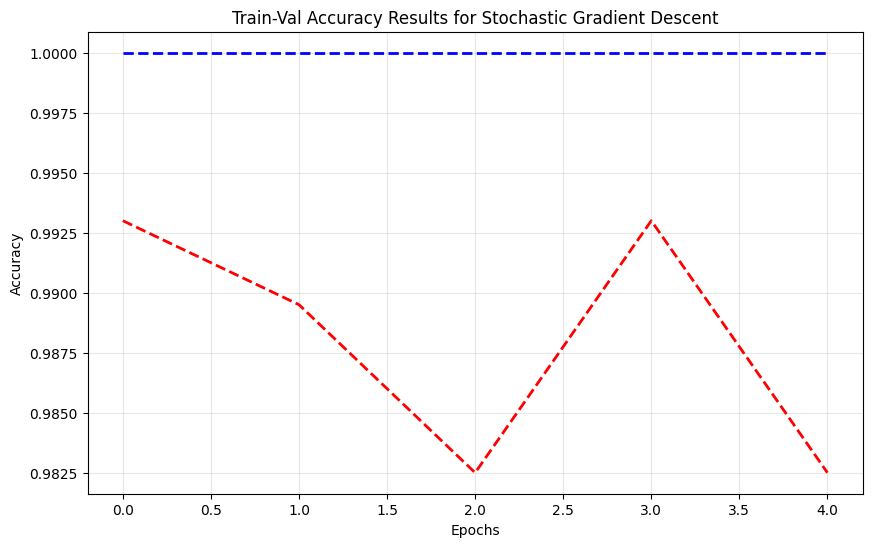

{'dataset': 'ling_stemmed_countvec', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965848105382988, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.996520474331804, 'macro_precision': 0.9883720930232558, 'macro_recall': 0.9979508196721312, 'macro_f1': 0.9930909530136489, 'roc_auc': 0.9979508196721312}, 'confusion_matrix': array([[243,   1],
       [  0,  42]], dtype=int64)}


Begin classifying Perceptron
Perceptron classification report


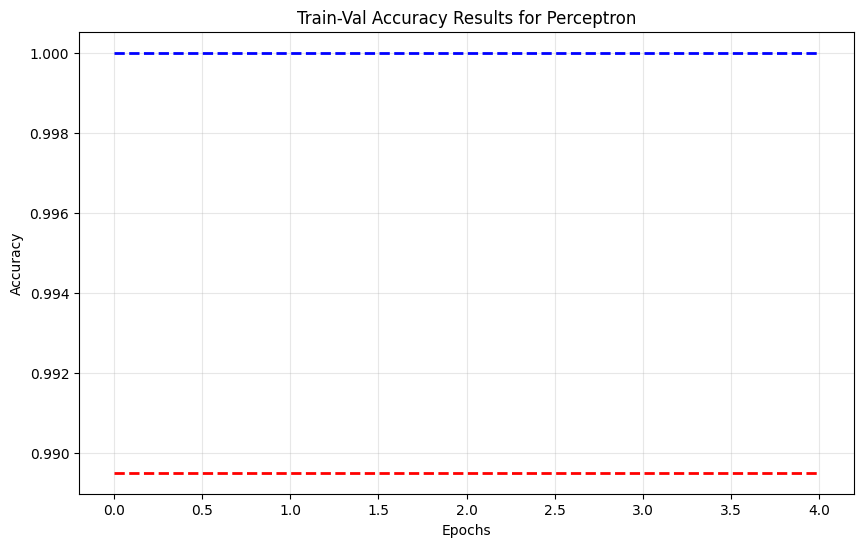

{'dataset': 'ling_stemmed_countvec', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9825174825174825, 'weighted_precision': 0.9834063585100928, 'wighted_recall': 0.9825174825174825, 'weighted_f1': 0.9827648355909999, 'macro_precision': 0.953480866758875, 'macro_recall': 0.9798985167837626, 'macro_f1': 0.9661097286408342, 'roc_auc': 0.9798985167837626}, 'confusion_matrix': array([[240,   4],
       [  1,  41]], dtype=int64)}


Begin classifying PassiveAggressiveClassifier
SVC classification report


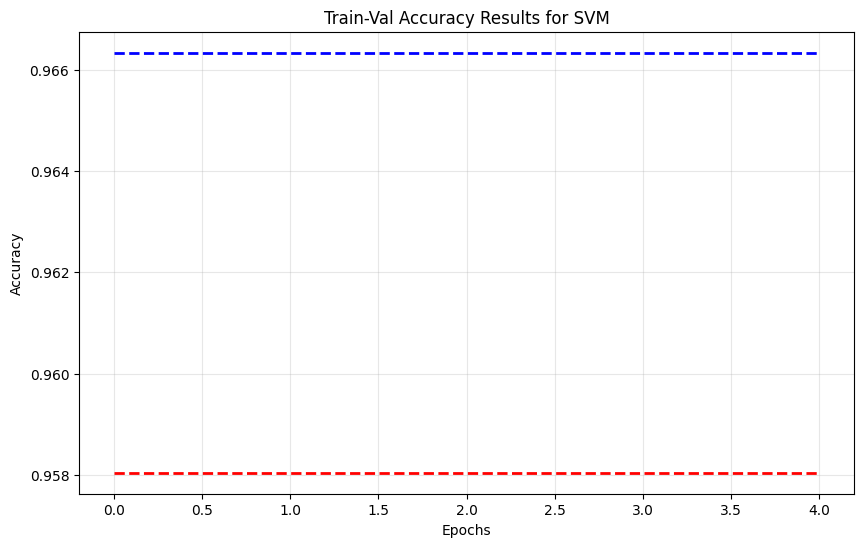

PassiveAggressiveClassifier classification report


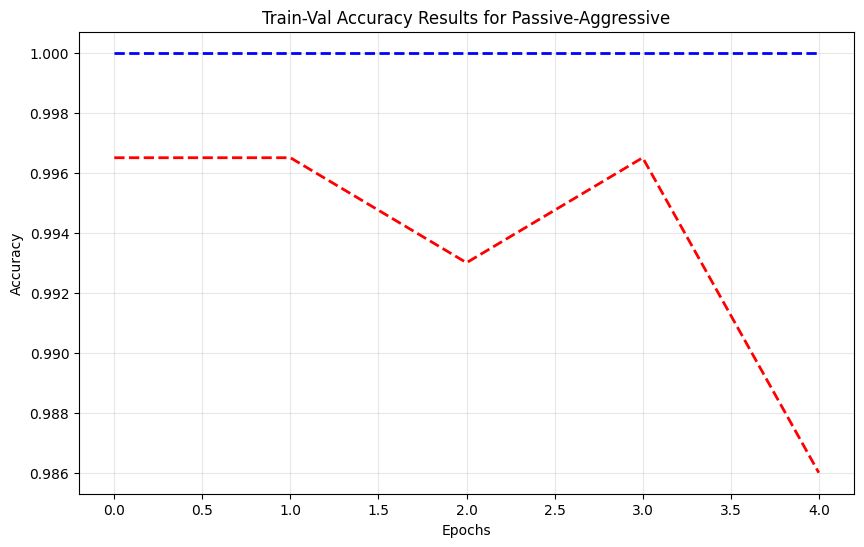

{'dataset': 'ling_stemmed_countvec', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965848105382988, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.996520474331804, 'macro_precision': 0.9883720930232558, 'macro_recall': 0.9979508196721312, 'macro_f1': 0.9930909530136489, 'roc_auc': 0.9979508196721312}, 'confusion_matrix': array([[243,   1],
       [  0,  42]], dtype=int64)}


Begin classifying MLPClassifier
{'dataset': 'ling_stemmed_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.965034965034965, 'weighted_precision': 0.9664115412146909, 'wighted_recall': 0.965034965034965, 'weighted_f1': 0.9630235172403847, 'macro_precision': 0.9803149606299213, 'macro_recall': 0.8809523809523809, 'macro_f1': 0.922392271789862, 'roc_auc': 0.8809523809523809}, 'confusion_matrix': array([[244,   0],
       [ 10,  32]], dtype=int64)}


LogisticRegression classification report


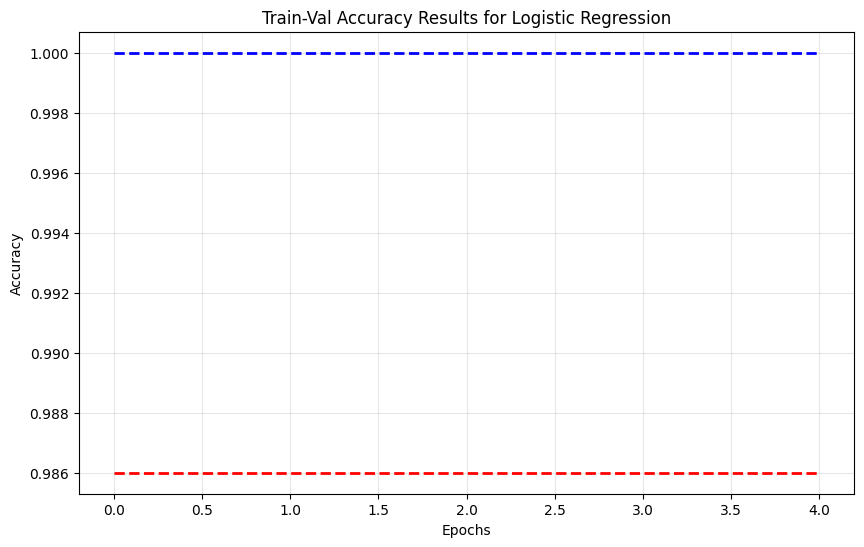

{'dataset': 'ling_stemmed_countvec', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965177679463395, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.9964860083863704, 'macro_precision': 0.9979591836734694, 'macro_recall': 0.9880952380952381, 'macro_f1': 0.9929534087269323, 'roc_auc': 0.9880952380952381}, 'confusion_matrix': array([[244,   0],
       [  1,  41]], dtype=int64)}


MLPClassifier classification report


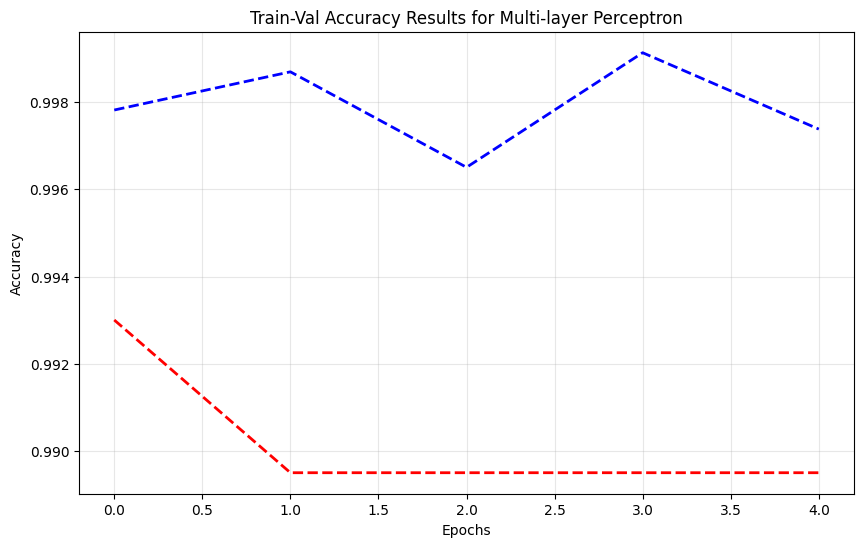

{'dataset': 'ling_stemmed_countvec', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.993006993006993, 'weighted_precision': 0.9930638467223832, 'wighted_recall': 0.993006993006993, 'weighted_f1': 0.9929359838767505, 'macro_precision': 0.9959349593495934, 'macro_recall': 0.9761904761904762, 'macro_f1': 0.9857640617222498, 'roc_auc': 0.9761904761904762}, 'confusion_matrix': array([[244,   0],
       [  2,  40]], dtype=int64)}




In [15]:
train_and_evaluate_model(ling_stemming_countvec, ling["label"], "ling_stemmed_countvec", model)
del ling_stemming_countvec
model = None

## Stemming + TF-IDF

In [16]:
model = get_classification_models()

ling_stemmed_tfidf classification report
Begin classifying SVC
Begin classifying MultinomialNB
Begin classifying BernoulliNB
MultinomialNB classification report


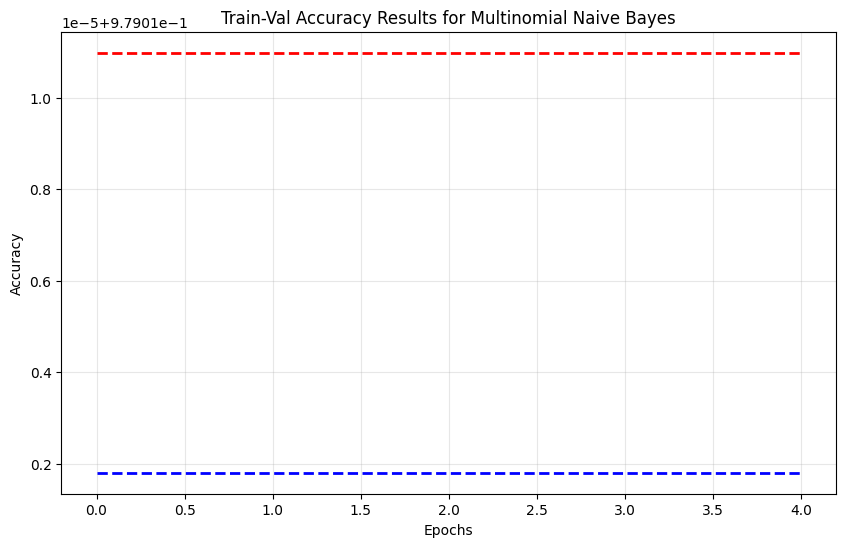

{'dataset': 'ling_stemmed_tfidf', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9790209790209791, 'weighted_precision': 0.9795244755244755, 'wighted_recall': 0.9790209790209791, 'weighted_f1': 0.97834149656012, 'macro_precision': 0.988, 'macro_recall': 0.9285714285714286, 'macro_f1': 0.9554655870445343, 'roc_auc': 0.9285714285714286}, 'confusion_matrix': array([[244,   0],
       [  6,  36]], dtype=int64)}


Begin classifying RandomForestClassifier
BernoulliNB classification report


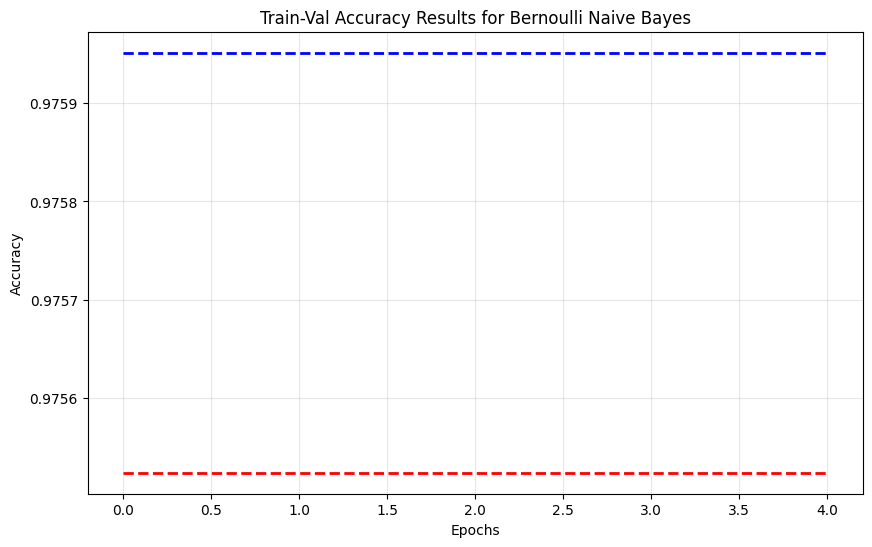

{'dataset': 'ling_stemmed_tfidf', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.986013986013986, 'weighted_precision': 0.9862395668847281, 'wighted_recall': 0.986013986013986, 'weighted_f1': 0.9857211893797259, 'macro_precision': 0.9919354838709677, 'macro_recall': 0.9523809523809523, 'macro_f1': 0.9709349593495935, 'roc_auc': 0.9523809523809523}, 'confusion_matrix': array([[244,   0],
       [  4,  38]], dtype=int64)}


Begin classifying DecisionTreeClassifier
DecisionTreeClassifier classification report


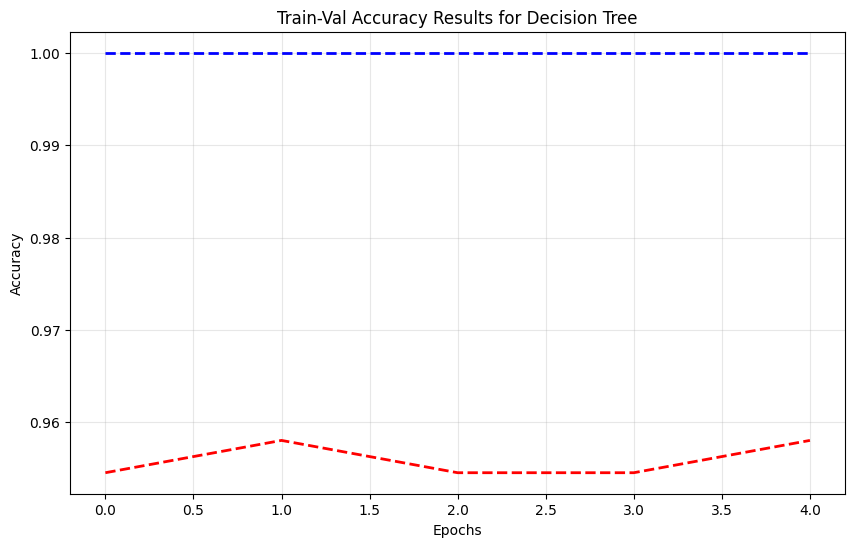

{'dataset': 'ling_stemmed_tfidf', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9685314685314685, 'weighted_precision': 0.9679793890320207, 'wighted_recall': 0.9685314685314685, 'weighted_f1': 0.9680448539919008, 'macro_precision': 0.9493927125506073, 'macro_recall': 0.922423887587822, 'macro_f1': 0.9352794749943426, 'roc_auc': 0.922423887587822}, 'confusion_matrix': array([[241,   3],
       [  6,  36]], dtype=int64)}


Begin classifying AdaBoostClassifier
RandomForestClassifier classification report


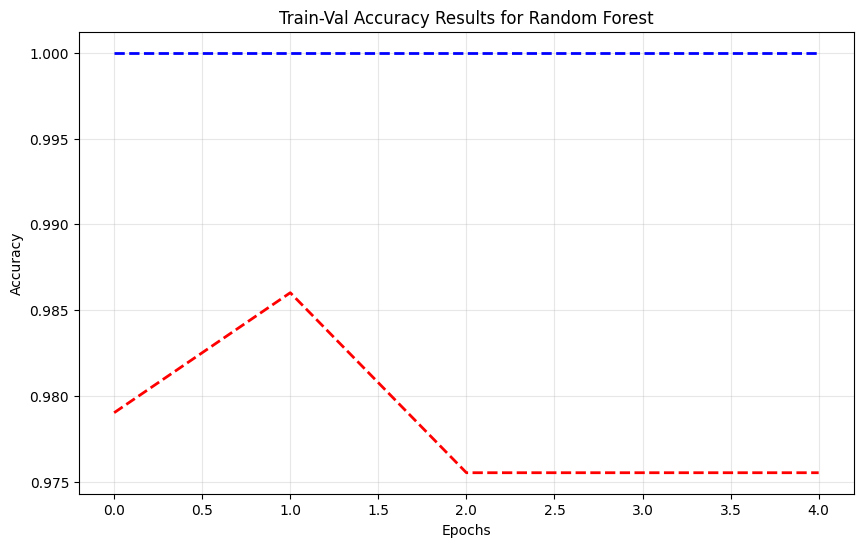

{'dataset': 'ling_stemmed_tfidf', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.986013986013986, 'weighted_precision': 0.9862395668847281, 'wighted_recall': 0.986013986013986, 'weighted_f1': 0.9857211893797259, 'macro_precision': 0.9919354838709677, 'macro_recall': 0.9523809523809523, 'macro_f1': 0.9709349593495935, 'roc_auc': 0.9523809523809523}, 'confusion_matrix': array([[244,   0],
       [  4,  38]], dtype=int64)}


Begin classifying LogisticRegression
LogisticRegression classification report


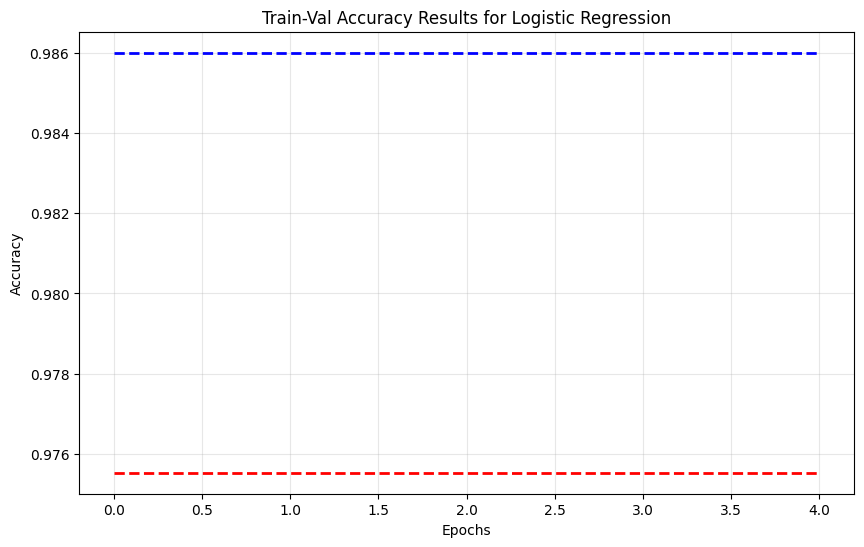

{'dataset': 'ling_stemmed_tfidf', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9790209790209791, 'weighted_precision': 0.9795244755244755, 'wighted_recall': 0.9790209790209791, 'weighted_f1': 0.97834149656012, 'macro_precision': 0.988, 'macro_recall': 0.9285714285714286, 'macro_f1': 0.9554655870445343, 'roc_auc': 0.9285714285714286}, 'confusion_matrix': array([[244,   0],
       [  6,  36]], dtype=int64)}


Begin classifying KNeighborsClassifier
SVC classification report


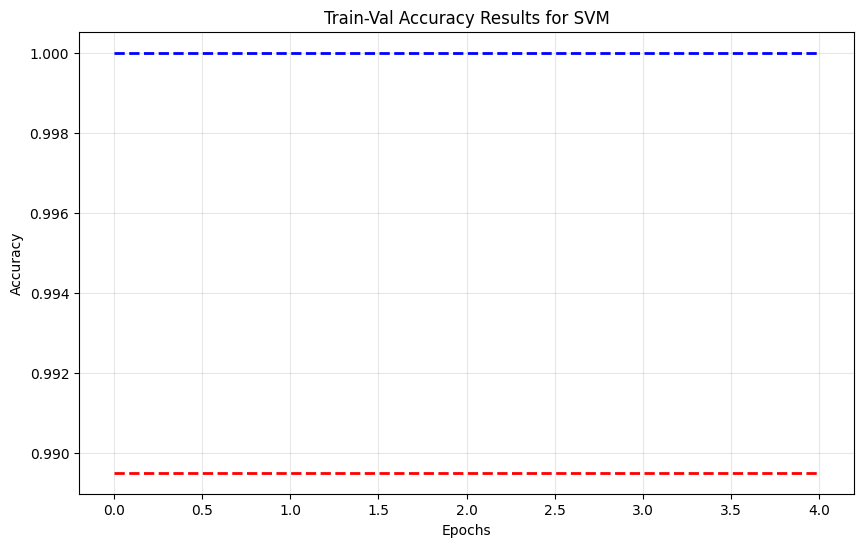

{'dataset': 'ling_stemmed_tfidf', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896378924719007, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9893482846639668, 'macro_precision': 0.9939271255060729, 'macro_recall': 0.9642857142857143, 'macro_f1': 0.9784264916647809, 'roc_auc': 0.9642857142857143}, 'confusion_matrix': array([[244,   0],
       [  3,  39]], dtype=int64)}


Begin classifying SGDClassifier
SGDClassifier classification report


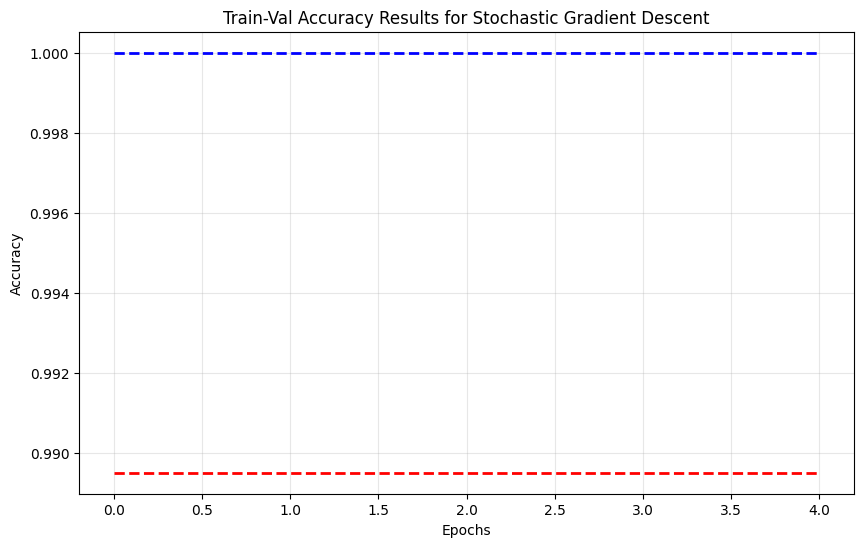

{'dataset': 'ling_stemmed_tfidf', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 1.0, 'weighted_precision': 1.0, 'wighted_recall': 1.0, 'weighted_f1': 1.0, 'macro_precision': 1.0, 'macro_recall': 1.0, 'macro_f1': 1.0, 'roc_auc': 1.0}, 'confusion_matrix': array([[244,   0],
       [  0,  42]], dtype=int64)}


Begin classifying Perceptron
Perceptron classification report


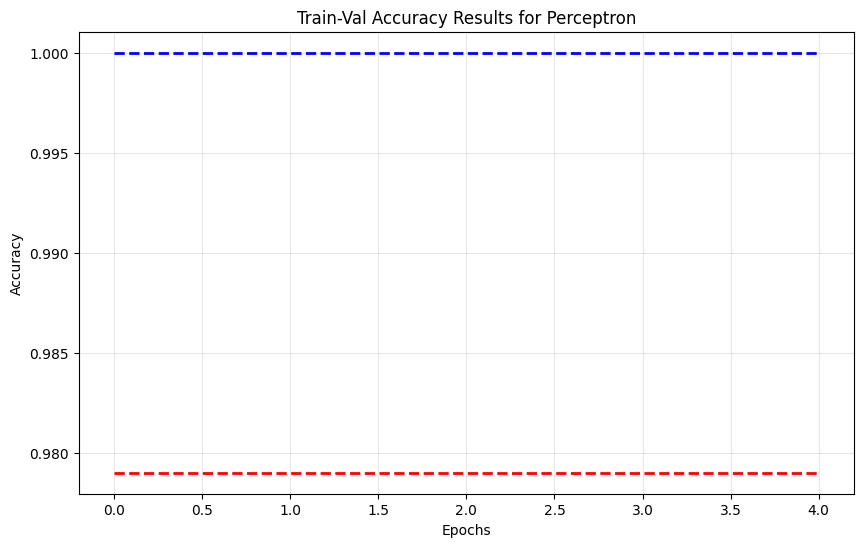

{'dataset': 'ling_stemmed_tfidf', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896587286768166, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9895614229954126, 'macro_precision': 0.9746865728777874, 'macro_recall': 0.9839968774395004, 'macro_f1': 0.979272859040947, 'roc_auc': 0.9839968774395004}, 'confusion_matrix': array([[242,   2],
       [  1,  41]], dtype=int64)}


Begin classifying PassiveAggressiveClassifier
PassiveAggressiveClassifier classification report


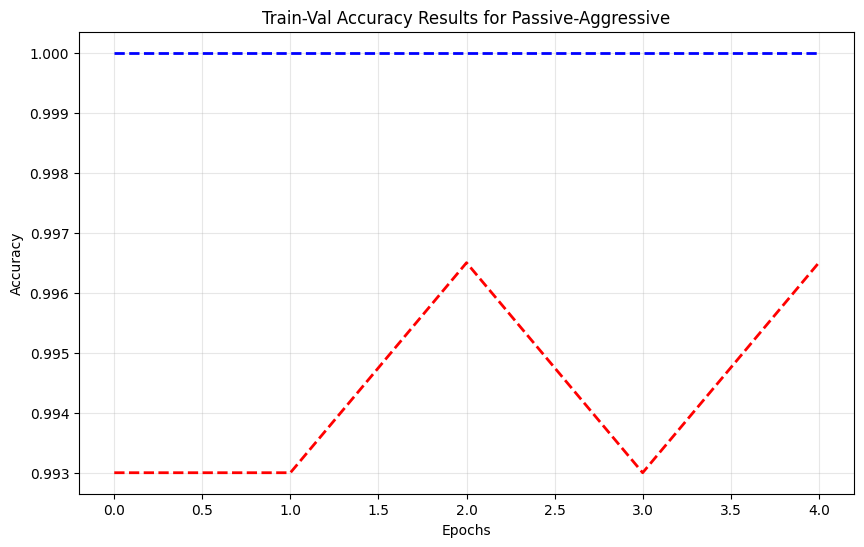

{'dataset': 'ling_stemmed_tfidf', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 1.0, 'weighted_precision': 1.0, 'wighted_recall': 1.0, 'weighted_f1': 1.0, 'macro_precision': 1.0, 'macro_recall': 1.0, 'macro_f1': 1.0, 'roc_auc': 1.0}, 'confusion_matrix': array([[244,   0],
       [  0,  42]], dtype=int64)}


Begin classifying MLPClassifier
AdaBoostClassifier classification report


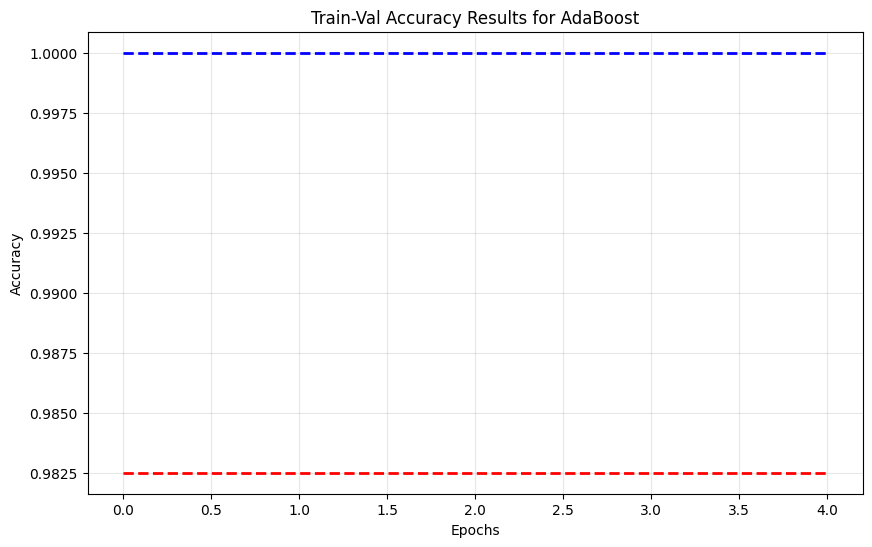

{'dataset': 'ling_stemmed_tfidf', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.993006993006993, 'weighted_precision': 0.993006993006993, 'wighted_recall': 0.993006993006993, 'weighted_f1': 0.993006993006993, 'macro_precision': 0.9860460577673693, 'macro_recall': 0.9860460577673693, 'macro_f1': 0.9860460577673693, 'roc_auc': 0.9860460577673694}, 'confusion_matrix': array([[243,   1],
       [  1,  41]], dtype=int64)}


KNeighborsClassifier classification report


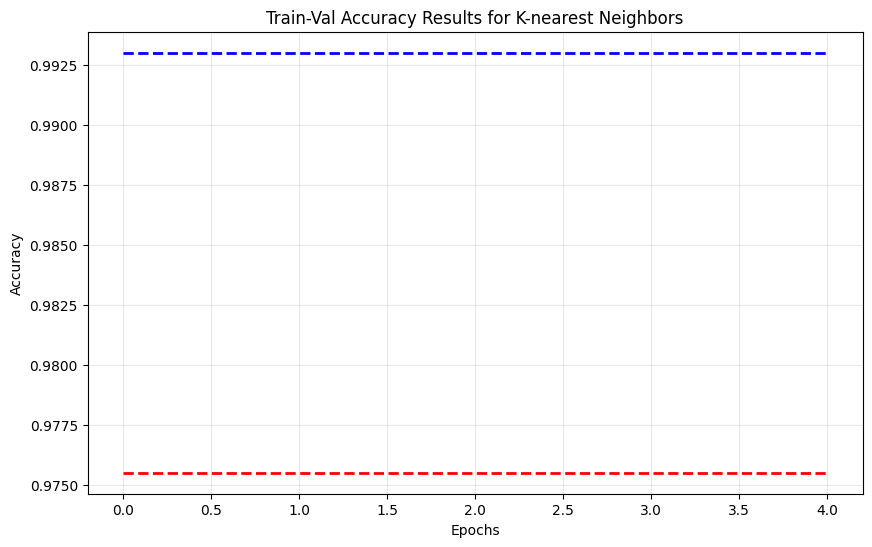

{'dataset': 'ling_stemmed_tfidf', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.986013986013986, 'weighted_precision': 0.986013986013986, 'wighted_recall': 0.986013986013986, 'weighted_f1': 0.986013986013986, 'macro_precision': 0.9720921155347384, 'macro_recall': 0.9720921155347384, 'macro_f1': 0.9720921155347384, 'roc_auc': 0.9720921155347385}, 'confusion_matrix': array([[242,   2],
       [  2,  40]], dtype=int64)}


MLPClassifier classification report


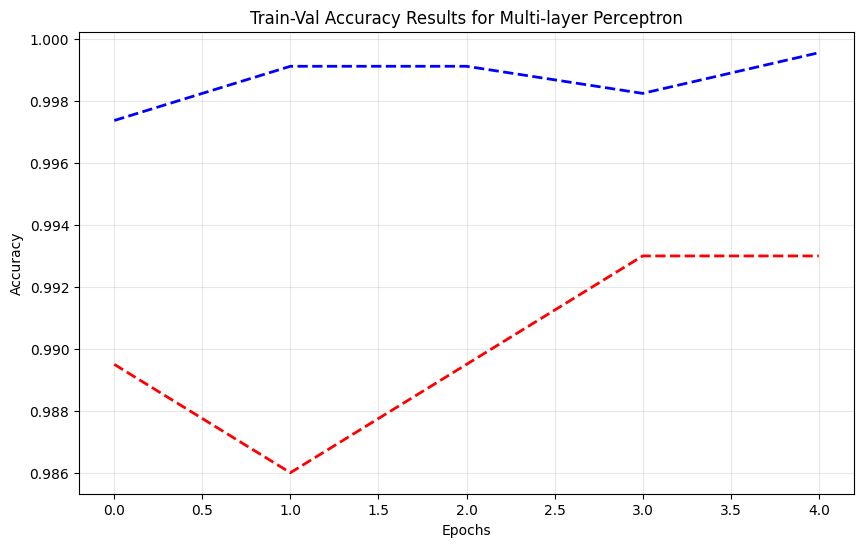

{'dataset': 'ling_stemmed_tfidf', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896378924719007, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9893482846639668, 'macro_precision': 0.9939271255060729, 'macro_recall': 0.9642857142857143, 'macro_f1': 0.9784264916647809, 'roc_auc': 0.9642857142857143}, 'confusion_matrix': array([[244,   0],
       [  3,  39]], dtype=int64)}




In [18]:
ling_stemming_tfidf = preprocessing.vectorizing(ling_stemming, "tfidf")

train_and_evaluate_model(ling_stemming_tfidf, ling["label"], "ling_stemmed_tfidf", model)
del ling_stemming_tfidf
del ling_stemming
model = None

## Lemmatizing + CountVectorizer

In [20]:
model = get_classification_models()

In [21]:
ling_lemmatizing = preprocessed_data.apply(preprocessing.lemmatizing)

ling_lemmatized_countvec classification report
Begin classifying SVC
Begin classifying MultinomialNB
Begin classifying BernoulliNB
MultinomialNB classification report
BernoulliNB classification report


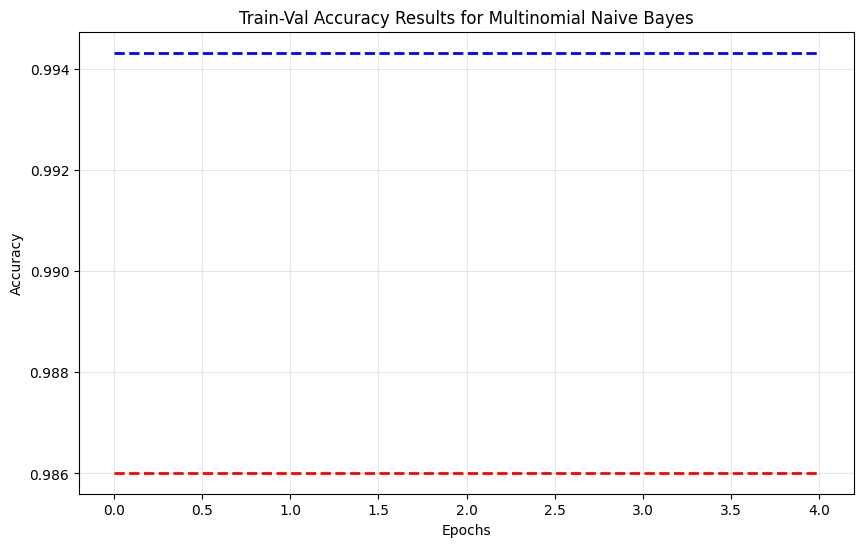

{'dataset': 'ling_lemmatized_countvec', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896587286768166, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9895614229954126, 'macro_precision': 0.9746865728777874, 'macro_recall': 0.9839968774395004, 'macro_f1': 0.979272859040947, 'roc_auc': 0.9839968774395004}, 'confusion_matrix': array([[242,   2],
       [  1,  41]], dtype=int64)}


Begin classifying RandomForestClassifier


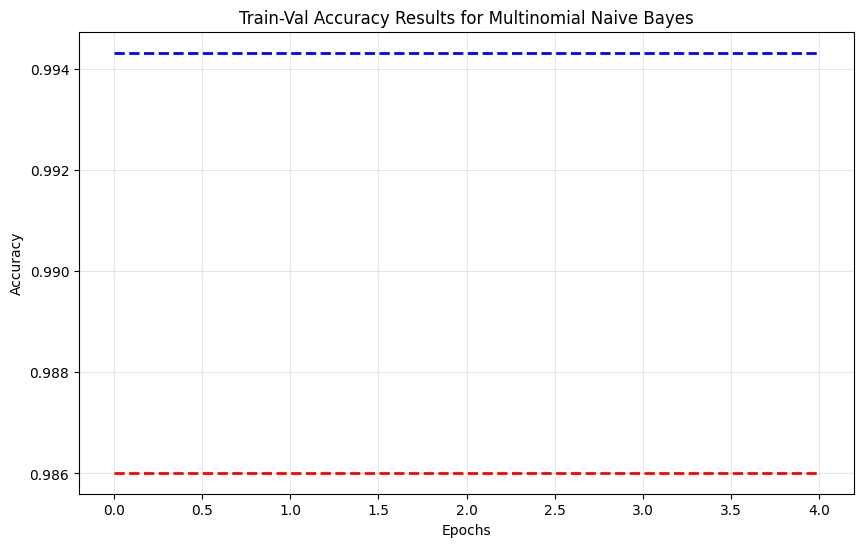

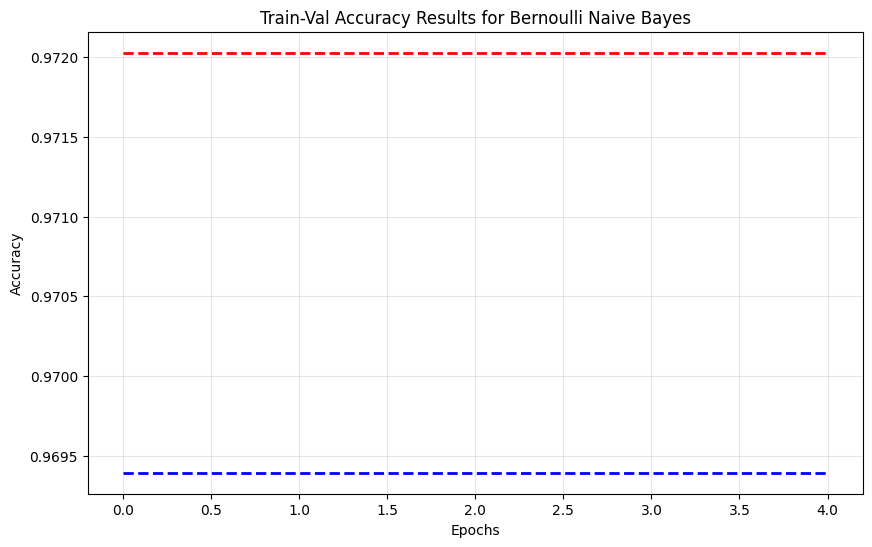

{'dataset': 'ling_lemmatized_countvec', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9790209790209791, 'weighted_precision': 0.9795244755244755, 'wighted_recall': 0.9790209790209791, 'weighted_f1': 0.97834149656012, 'macro_precision': 0.988, 'macro_recall': 0.9285714285714286, 'macro_f1': 0.9554655870445343, 'roc_auc': 0.9285714285714286}, 'confusion_matrix': array([[244,   0],
       [  6,  36]], dtype=int64)}


Begin classifying DecisionTreeClassifier
DecisionTreeClassifier classification report


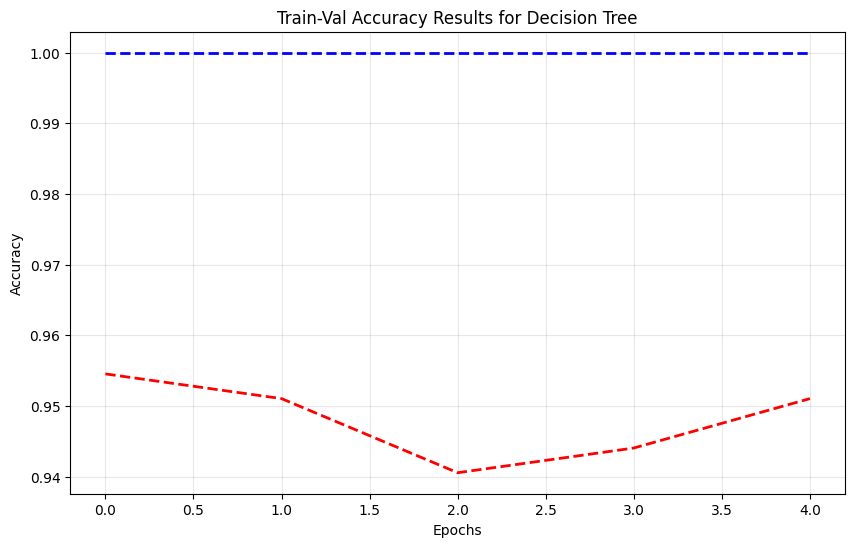

{'dataset': 'ling_lemmatized_countvec', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.9825174825174825, 'weighted_precision': 0.9834063585100928, 'wighted_recall': 0.9825174825174825, 'weighted_f1': 0.9827648355909999, 'macro_precision': 0.953480866758875, 'macro_recall': 0.9798985167837626, 'macro_f1': 0.9661097286408342, 'roc_auc': 0.9798985167837626}, 'confusion_matrix': array([[240,   4],
       [  1,  41]], dtype=int64)}


Begin classifying AdaBoostClassifier
RandomForestClassifier classification report


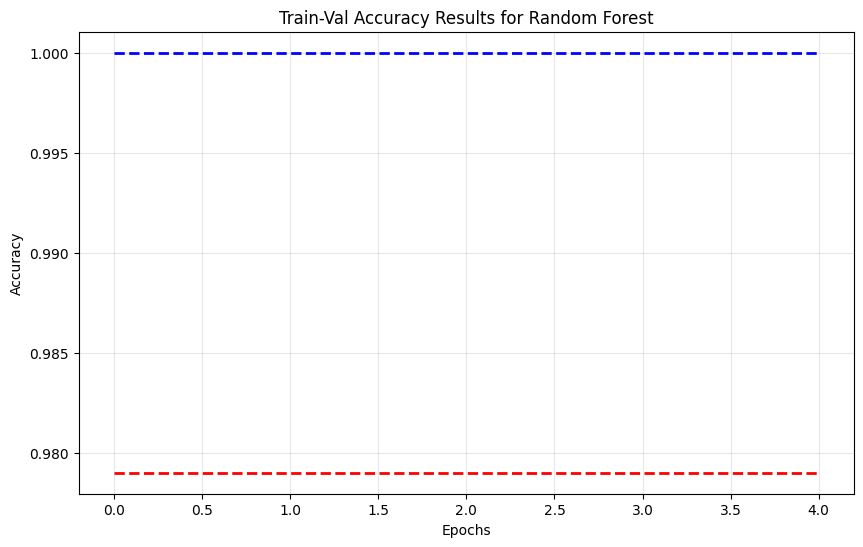

{'dataset': 'ling_lemmatized_countvec', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896378924719007, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9893482846639668, 'macro_precision': 0.9939271255060729, 'macro_recall': 0.9642857142857143, 'macro_f1': 0.9784264916647809, 'roc_auc': 0.9642857142857143}, 'confusion_matrix': array([[244,   0],
       [  3,  39]], dtype=int64)}


Begin classifying LogisticRegression
AdaBoostClassifier classification report


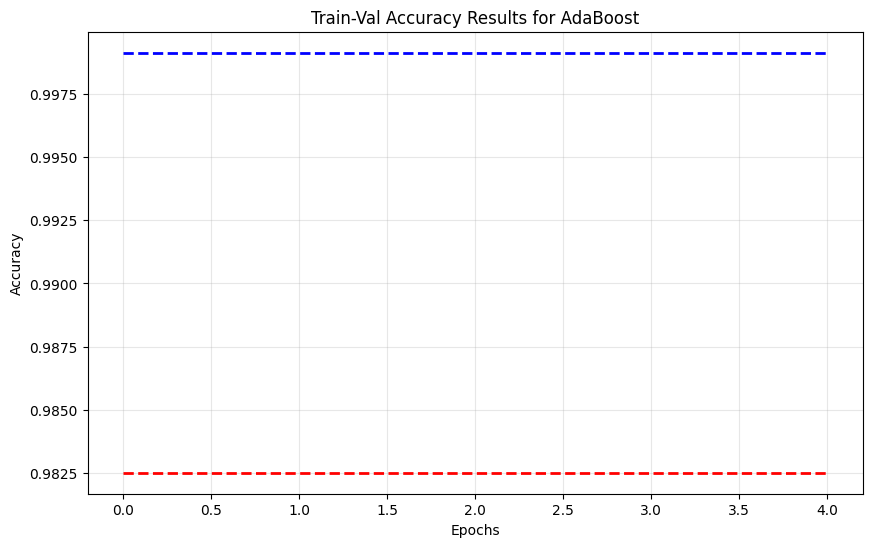

{'dataset': 'ling_lemmatized_countvec', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965848105382988, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.996520474331804, 'macro_precision': 0.9883720930232558, 'macro_recall': 0.9979508196721312, 'macro_f1': 0.9930909530136489, 'roc_auc': 0.9979508196721312}, 'confusion_matrix': array([[243,   1],
       [  0,  42]], dtype=int64)}


Begin classifying KNeighborsClassifier
SVC classification report


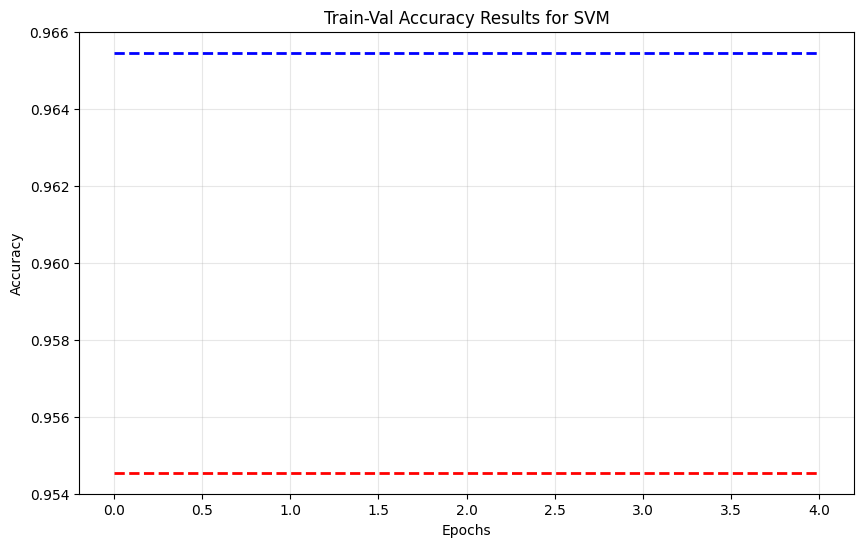

{'dataset': 'ling_lemmatized_countvec', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.965034965034965, 'weighted_precision': 0.9664115412146909, 'wighted_recall': 0.965034965034965, 'weighted_f1': 0.9630235172403847, 'macro_precision': 0.9803149606299213, 'macro_recall': 0.8809523809523809, 'macro_f1': 0.922392271789862, 'roc_auc': 0.8809523809523809}, 'confusion_matrix': array([[244,   0],
       [ 10,  32]], dtype=int64)}


Begin classifying SGDClassifier
SGDClassifier classification report


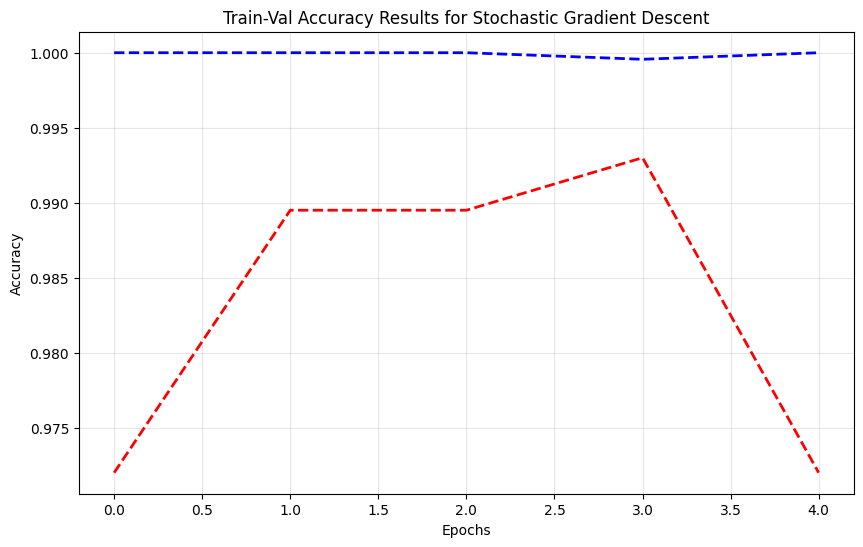

{'dataset': 'ling_lemmatized_countvec', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 0.972027972027972, 'weighted_precision': 0.972027972027972, 'wighted_recall': 0.972027972027972, 'weighted_f1': 0.972027972027972, 'macro_precision': 0.944184231069477, 'macro_recall': 0.944184231069477, 'macro_f1': 0.944184231069477, 'roc_auc': 0.9441842310694769}, 'confusion_matrix': array([[240,   4],
       [  4,  38]], dtype=int64)}


Begin classifying Perceptron
Perceptron classification report


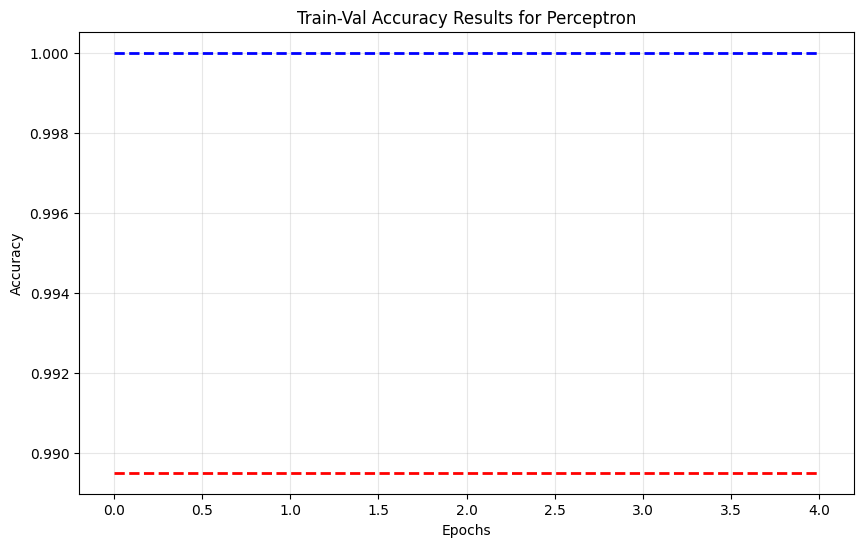

{'dataset': 'ling_lemmatized_countvec', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9902097902097902, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9896589013545998, 'macro_precision': 0.9666666666666667, 'macro_recall': 0.9938524590163935, 'macro_f1': 0.9796658371845005, 'roc_auc': 0.9938524590163935}, 'confusion_matrix': array([[241,   3],
       [  0,  42]], dtype=int64)}


Begin classifying PassiveAggressiveClassifier
KNeighborsClassifier classification report
PassiveAggressiveClassifier classification report


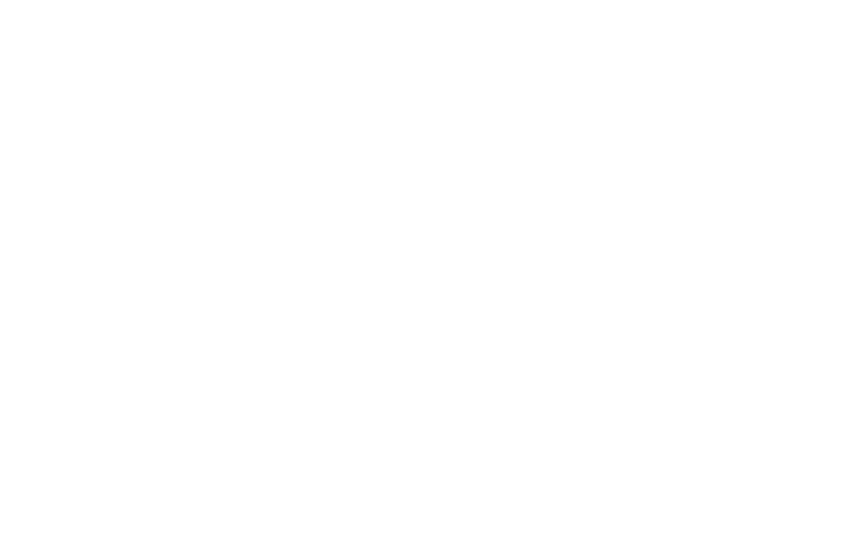

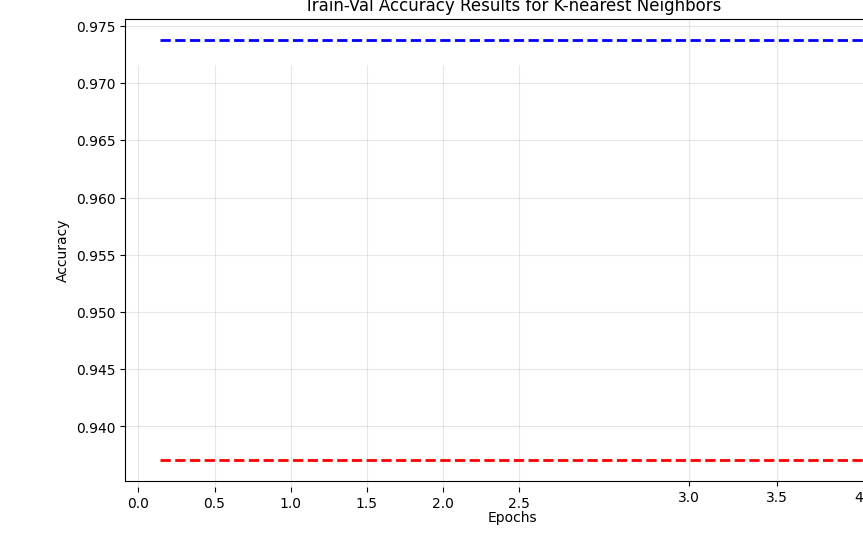

LogisticRegression classification report
{'dataset': 'ling_lemmatized_countvec', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.9370629370629371, 'weighted_precision': 0.9458789074173689, 'wighted_recall': 0.9370629370629371, 'weighted_f1': 0.9397523156981895, 'macro_precision': 0.8568376068376068, 'macro_recall': 0.9236924277907885, 'macro_f1': 0.885426867266091, 'roc_auc': 0.9236924277907884}, 'confusion_matrix': array([[230,  14],
       [  4,  38]], dtype=int64)}


Begin classifying MLPClassifier


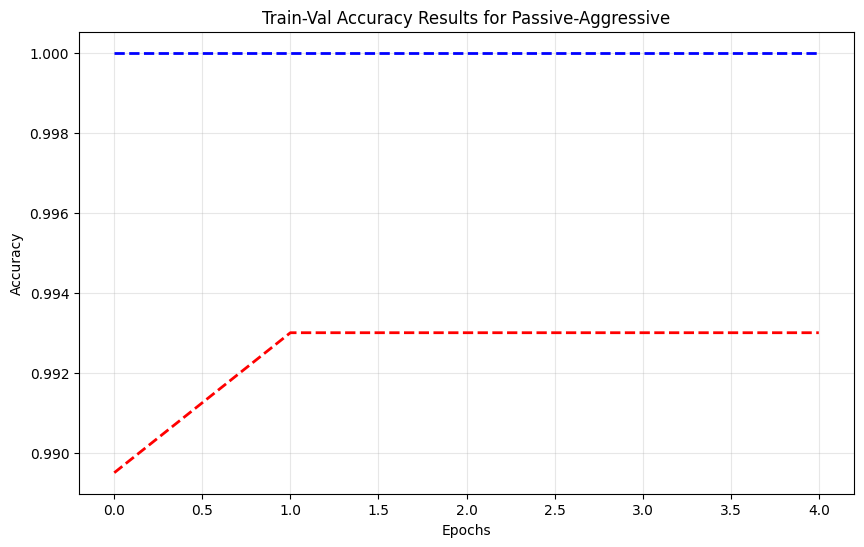

{'dataset': 'ling_lemmatized_countvec', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965848105382988, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.996520474331804, 'macro_precision': 0.9883720930232558, 'macro_recall': 0.9979508196721312, 'macro_f1': 0.9930909530136489, 'roc_auc': 0.9979508196721312}, 'confusion_matrix': array([[243,   1],
       [  0,  42]], dtype=int64)}




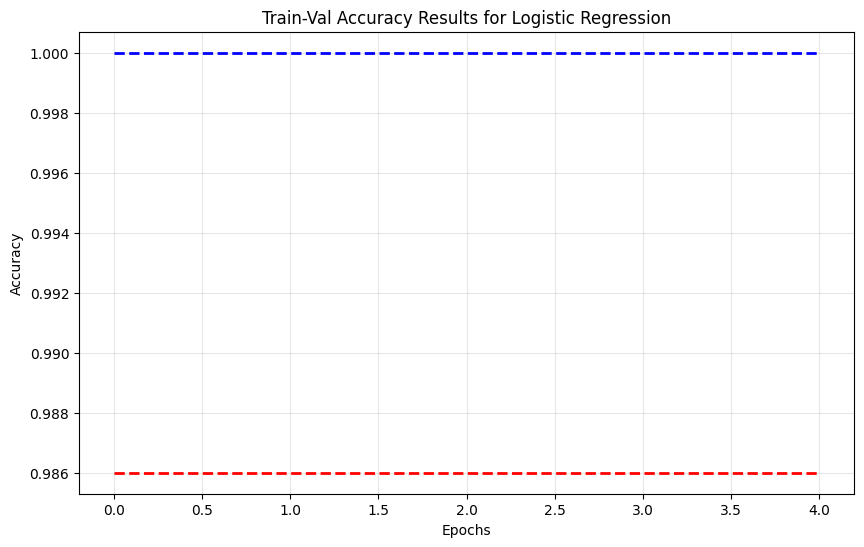

{'dataset': 'ling_lemmatized_countvec', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965177679463395, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.9964860083863704, 'macro_precision': 0.9979591836734694, 'macro_recall': 0.9880952380952381, 'macro_f1': 0.9929534087269323, 'roc_auc': 0.9880952380952381}, 'confusion_matrix': array([[244,   0],
       [  1,  41]], dtype=int64)}


MLPClassifier classification report


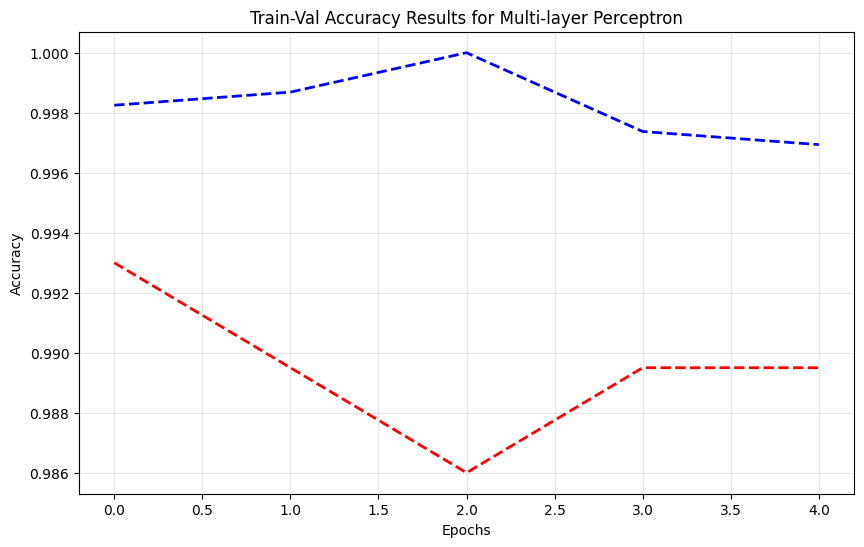

{'dataset': 'ling_lemmatized_countvec', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9965034965034965, 'weighted_precision': 0.9965177679463395, 'wighted_recall': 0.9965034965034965, 'weighted_f1': 0.9964860083863704, 'macro_precision': 0.9979591836734694, 'macro_recall': 0.9880952380952381, 'macro_f1': 0.9929534087269323, 'roc_auc': 0.9880952380952381}, 'confusion_matrix': array([[244,   0],
       [  1,  41]], dtype=int64)}




In [22]:
ling_lemmatizing_countvec = preprocessing.vectorizing(ling_lemmatizing, "countvectorizer")

train_and_evaluate_model(ling_lemmatizing_countvec, ling["label"], "ling_lemmatized_countvec", model)
del ling_lemmatizing_countvec
model = None

## Lemmatizing + TF-IDF

In [23]:
model = get_classification_models()

ling_lemmatized_tfidf classification report
Begin classifying SVC
Begin classifying MultinomialNB
Begin classifying BernoulliNB
MultinomialNB classification report
BernoulliNB classification report


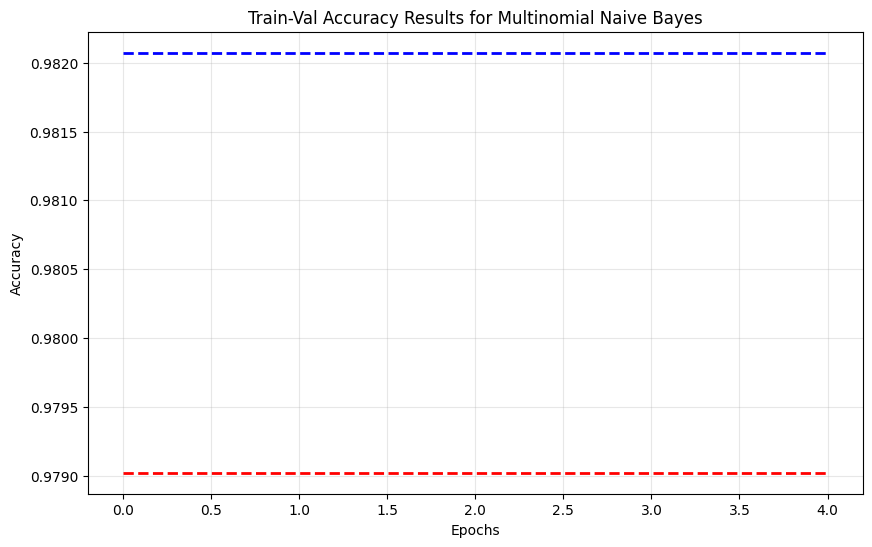

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Multinomial Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9825174825174825, 'weighted_precision': 0.9828685370854046, 'wighted_recall': 0.9825174825174825, 'weighted_f1': 0.9820528920331216, 'macro_precision': 0.9899598393574297, 'macro_recall': 0.9404761904761905, 'macro_f1': 0.9632834364649395, 'roc_auc': 0.9404761904761905}, 'confusion_matrix': array([[244,   0],
       [  5,  37]], dtype=int64)}


Begin classifying RandomForestClassifier


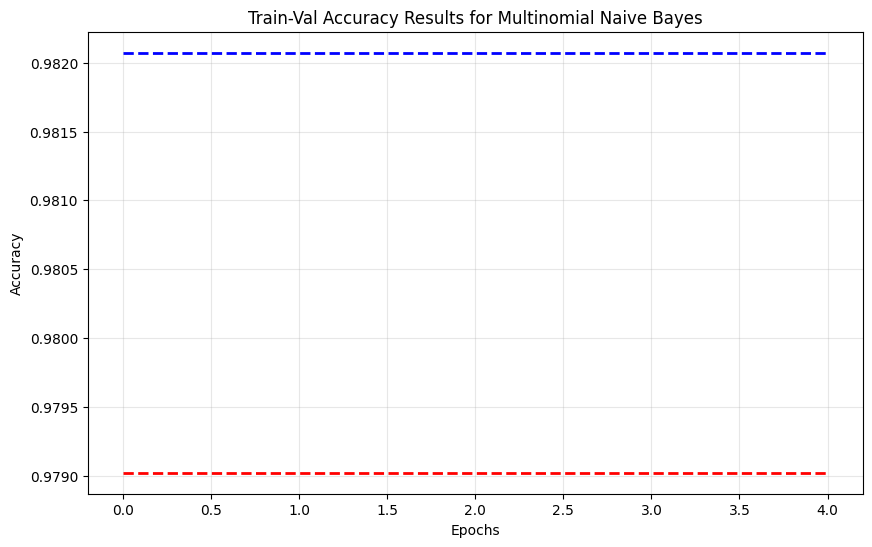

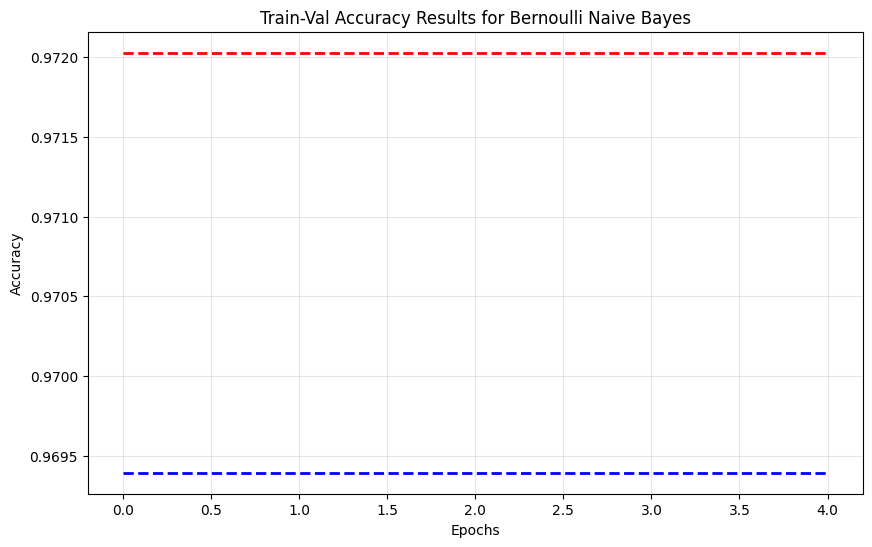

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Bernoulli Naive Bayes', 'type': 'normal', 'metrics': {'accuracy': 0.9790209790209791, 'weighted_precision': 0.9795244755244755, 'wighted_recall': 0.9790209790209791, 'weighted_f1': 0.97834149656012, 'macro_precision': 0.988, 'macro_recall': 0.9285714285714286, 'macro_f1': 0.9554655870445343, 'roc_auc': 0.9285714285714286}, 'confusion_matrix': array([[244,   0],
       [  6,  36]], dtype=int64)}


Begin classifying DecisionTreeClassifier
DecisionTreeClassifier classification report


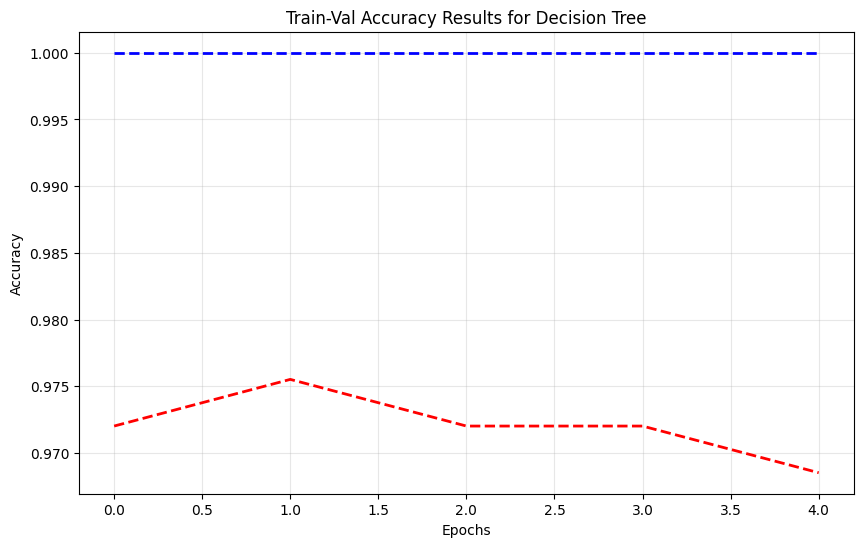

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Decision Tree', 'type': 'normal', 'metrics': {'accuracy': 0.951048951048951, 'weighted_precision': 0.951048951048951, 'wighted_recall': 0.951048951048951, 'weighted_f1': 0.951048951048951, 'macro_precision': 0.9023224043715847, 'macro_recall': 0.9023224043715847, 'macro_f1': 0.9023224043715847, 'roc_auc': 0.9023224043715848}, 'confusion_matrix': array([[237,   7],
       [  7,  35]], dtype=int64)}


Begin classifying AdaBoostClassifier
RandomForestClassifier classification report


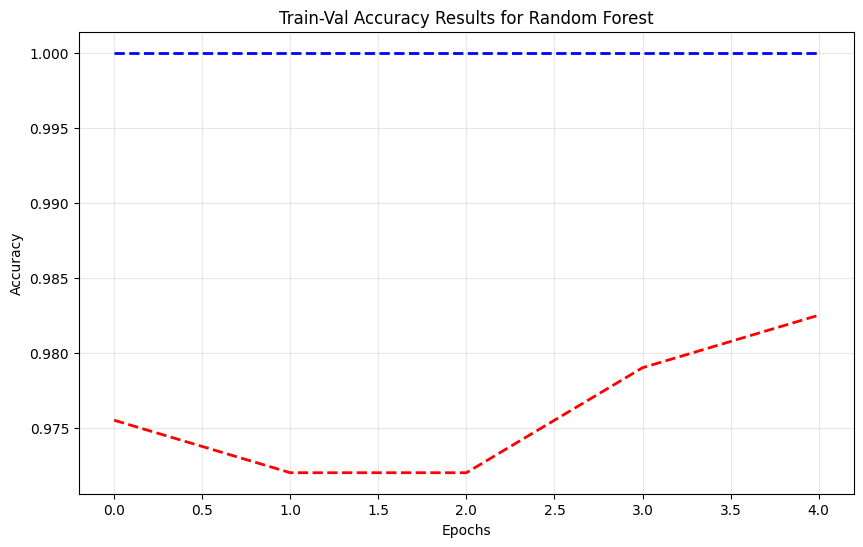

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Random Forest', 'type': 'normal', 'metrics': {'accuracy': 0.986013986013986, 'weighted_precision': 0.9862395668847281, 'wighted_recall': 0.986013986013986, 'weighted_f1': 0.9857211893797259, 'macro_precision': 0.9919354838709677, 'macro_recall': 0.9523809523809523, 'macro_f1': 0.9709349593495935, 'roc_auc': 0.9523809523809523}, 'confusion_matrix': array([[244,   0],
       [  4,  38]], dtype=int64)}


Begin classifying LogisticRegression
LogisticRegression classification report


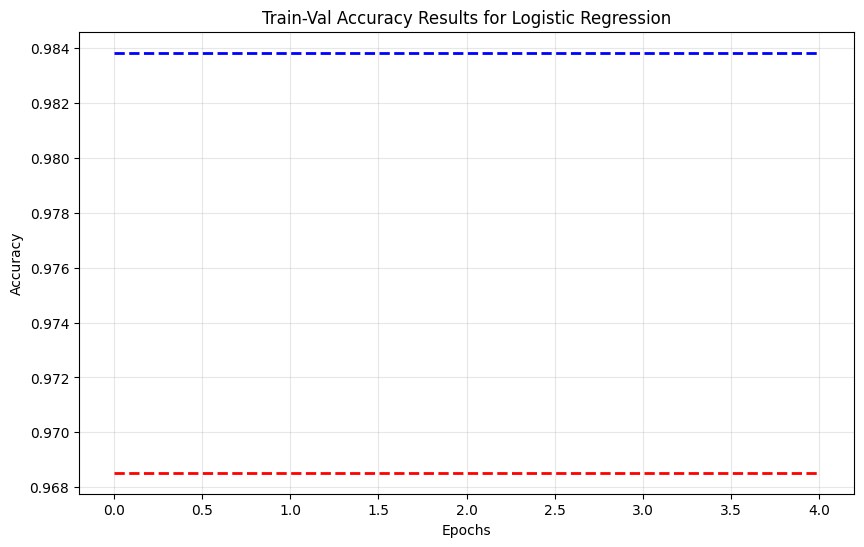

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Logistic Regression', 'type': 'normal', 'metrics': {'accuracy': 0.9790209790209791, 'weighted_precision': 0.9795244755244755, 'wighted_recall': 0.9790209790209791, 'weighted_f1': 0.97834149656012, 'macro_precision': 0.988, 'macro_recall': 0.9285714285714286, 'macro_f1': 0.9554655870445343, 'roc_auc': 0.9285714285714286}, 'confusion_matrix': array([[244,   0],
       [  6,  36]], dtype=int64)}


Begin classifying KNeighborsClassifier
SVC classification report


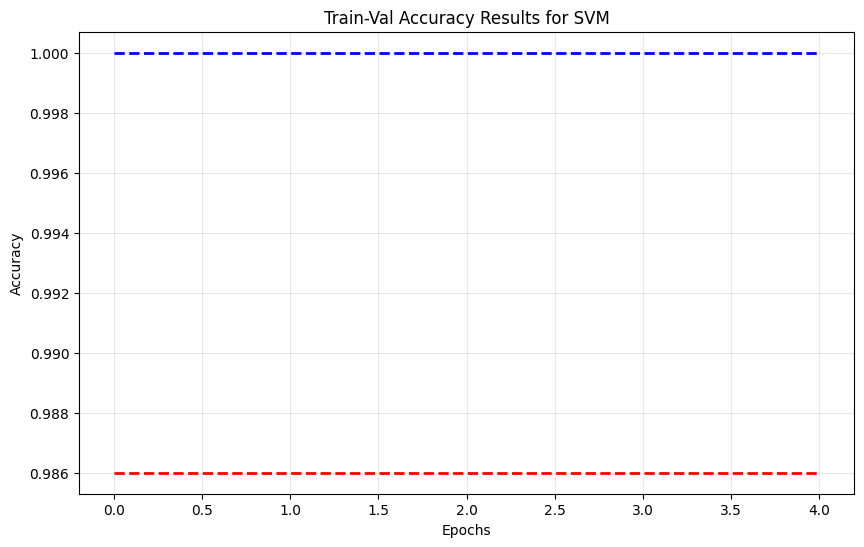

{'dataset': 'ling_lemmatized_tfidf', 'model': 'SVM', 'type': 'normal', 'metrics': {'accuracy': 0.993006993006993, 'weighted_precision': 0.9930638467223832, 'wighted_recall': 0.993006993006993, 'weighted_f1': 0.9929359838767505, 'macro_precision': 0.9959349593495934, 'macro_recall': 0.9761904761904762, 'macro_f1': 0.9857640617222498, 'roc_auc': 0.9761904761904762}, 'confusion_matrix': array([[244,   0],
       [  2,  40]], dtype=int64)}


Begin classifying SGDClassifier
SGDClassifier classification report


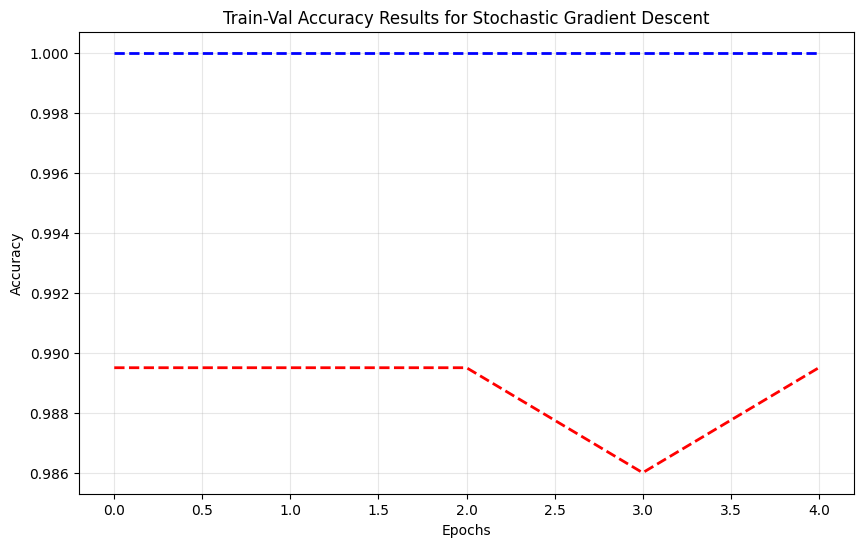

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Stochastic Gradient Descent', 'type': 'normal', 'metrics': {'accuracy': 1.0, 'weighted_precision': 1.0, 'wighted_recall': 1.0, 'weighted_f1': 1.0, 'macro_precision': 1.0, 'macro_recall': 1.0, 'macro_f1': 1.0, 'roc_auc': 1.0}, 'confusion_matrix': array([[244,   0],
       [  0,  42]], dtype=int64)}


Begin classifying Perceptron
Perceptron classification report


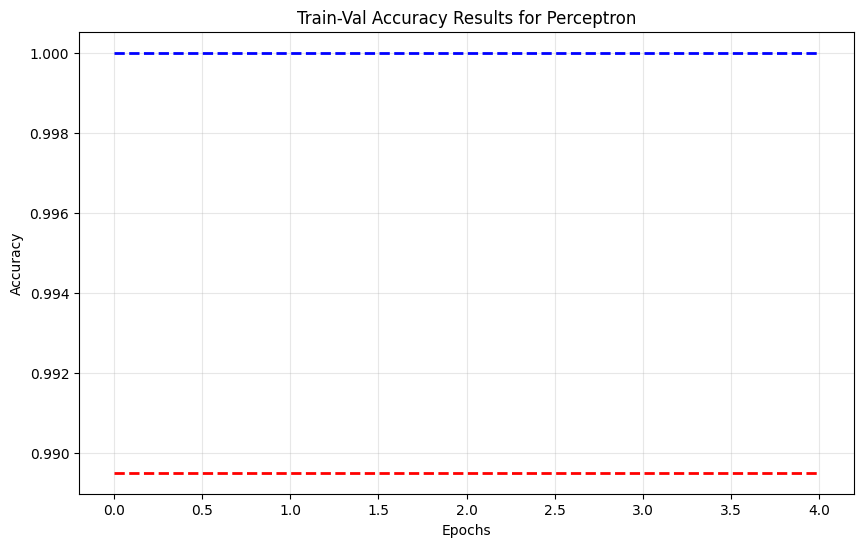

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9894537518230898, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9894580251591117, 'macro_precision': 0.9837232453957192, 'macro_recall': 0.9741412958626073, 'macro_f1': 0.9788602261807968, 'roc_auc': 0.9741412958626073}, 'confusion_matrix': array([[243,   1],
       [  2,  40]], dtype=int64)}


Begin classifying PassiveAggressiveClassifier
PassiveAggressiveClassifier classification report


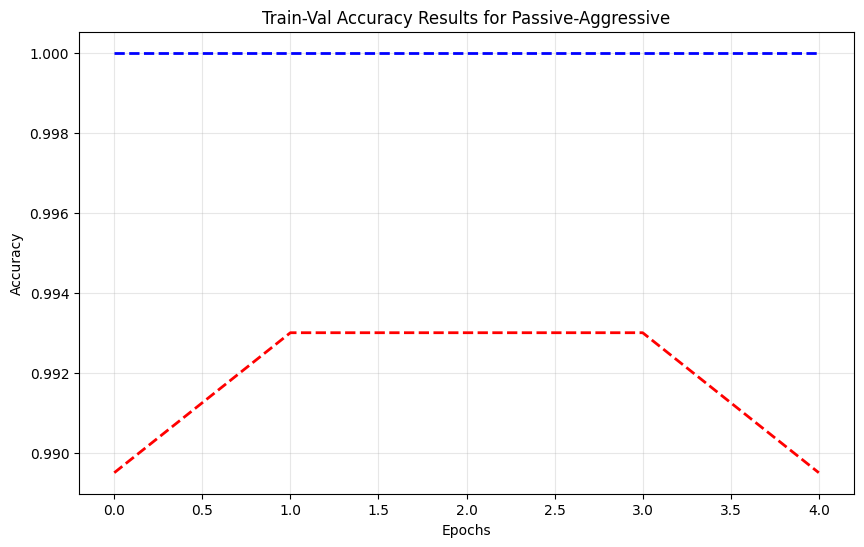

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Passive-Aggressive', 'type': 'normal', 'metrics': {'accuracy': 1.0, 'weighted_precision': 1.0, 'wighted_recall': 1.0, 'weighted_f1': 1.0, 'macro_precision': 1.0, 'macro_recall': 1.0, 'macro_f1': 1.0, 'roc_auc': 1.0}, 'confusion_matrix': array([[244,   0],
       [  0,  42]], dtype=int64)}


Begin classifying MLPClassifier
AdaBoostClassifier classification report


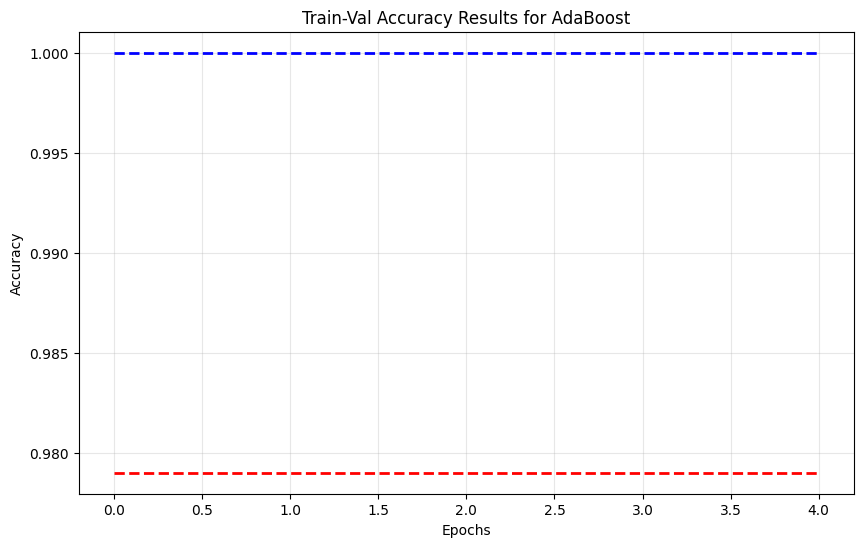

{'dataset': 'ling_lemmatized_tfidf', 'model': 'AdaBoost', 'type': 'normal', 'metrics': {'accuracy': 1.0, 'weighted_precision': 1.0, 'wighted_recall': 1.0, 'weighted_f1': 1.0, 'macro_precision': 1.0, 'macro_recall': 1.0, 'macro_f1': 1.0, 'roc_auc': 1.0}, 'confusion_matrix': array([[244,   0],
       [  0,  42]], dtype=int64)}


KNeighborsClassifier classification report


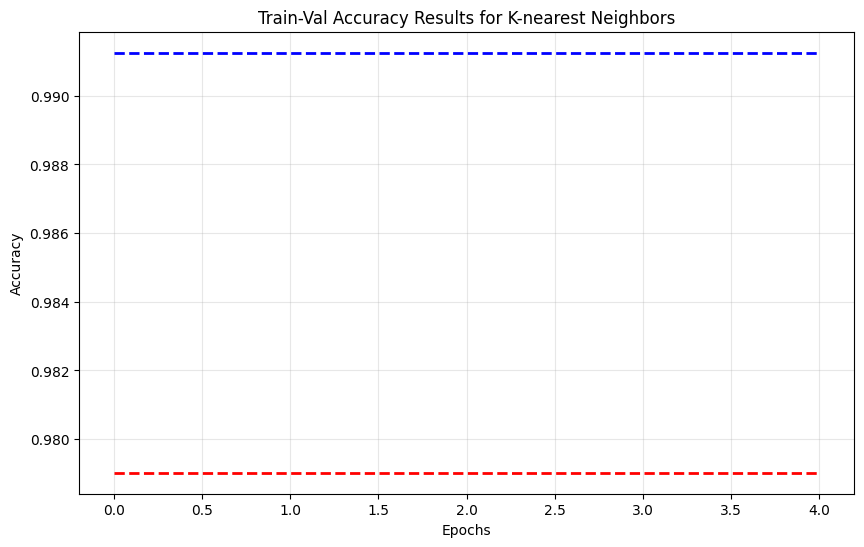

{'dataset': 'ling_lemmatized_tfidf', 'model': 'K-nearest Neighbors', 'type': 'normal', 'metrics': {'accuracy': 0.9755244755244755, 'weighted_precision': 0.9766029268103957, 'wighted_recall': 0.9755244755244755, 'weighted_f1': 0.9758707698274, 'macro_precision': 0.9402950668510834, 'macro_recall': 0.9659445745511319, 'macro_f1': 0.9525536200971679, 'roc_auc': 0.9659445745511319}, 'confusion_matrix': array([[239,   5],
       [  2,  40]], dtype=int64)}


MLPClassifier classification report


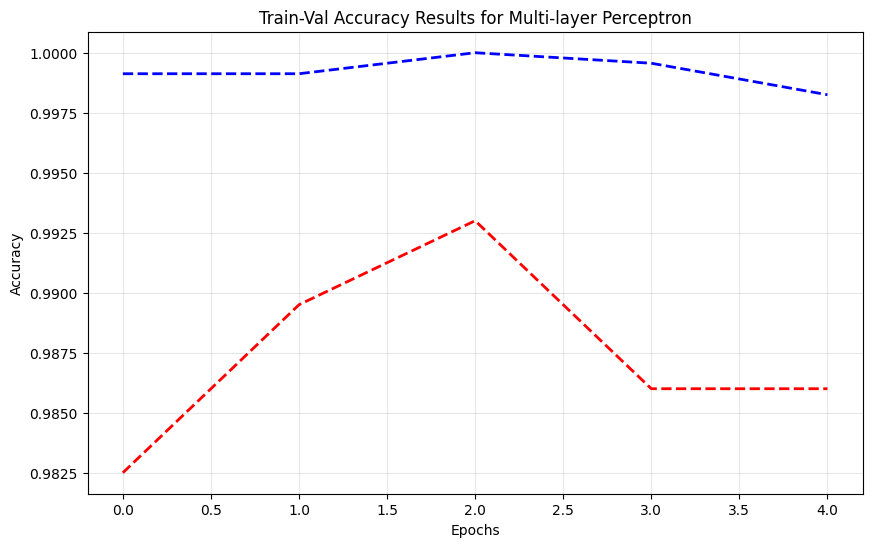

{'dataset': 'ling_lemmatized_tfidf', 'model': 'Multi-layer Perceptron', 'type': 'normal', 'metrics': {'accuracy': 0.9895104895104895, 'weighted_precision': 0.9896378924719007, 'wighted_recall': 0.9895104895104895, 'weighted_f1': 0.9893482846639668, 'macro_precision': 0.9939271255060729, 'macro_recall': 0.9642857142857143, 'macro_f1': 0.9784264916647809, 'roc_auc': 0.9642857142857143}, 'confusion_matrix': array([[244,   0],
       [  3,  39]], dtype=int64)}




In [24]:
ling_lemmatizing_tfidf = preprocessing.vectorizing(ling_lemmatizing, "tfidf")

train_and_evaluate_model(ling_lemmatizing_tfidf, ling["label"], "ling_lemmatized_tfidf", model)

del ling_lemmatizing_tfidf
del ling_lemmatizing
model = None

In [25]:
def convert(dic):
    dic["confusion_matrix"] = dic["confusion_matrix"].tolist()
    return dic

metric_results = list(map(convert, metric_results))

add_to_json_array("./ling_classification_report.json", metric_results, mode="overwrite")